In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from dataProcessing import getANSZData, DataProcessing

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
from ElapsedTime import ElapsedTime

dropout = 0.5
minL2 = -8
maxL2 = 2
l2Arr = np.logspace(minL2, maxL2, -(minL2-maxL2)+1)
patience = 10
batch_size = 4096
early_stopping=EarlyStopping(patience=patience, restore_best_weights=True, verbose=1)

columns_to_test = ['Temperature', 'Humidity', 'Blast', 'Rain', 'WindSpeed', 'WindDirection']
modelArr = []
hstArr = []
for l in range(0, len(columns_to_test)):
    train_data_many_day_x, train_data_many_day_y, dev_data_many_day_x, dev_data_many_day_y, \
            test_data_many_day_x, test_data_many_day_y = getANSZData(n_days=30, columns=columns_to_test[:l+1])
    pr = DataProcessing(train_data_many_day_x, train_data_many_day_y)
    train_data_many_day_x = pr.preprocessInput(train_data_many_day_x)
    dev_data_many_day_x = pr.preprocessInput(dev_data_many_day_x)
    test_data_many_day_x = pr.preprocessInput(test_data_many_day_x)
    train_data_many_day_y = pr.preprocessOutput(train_data_many_day_y)
    dev_data_many_day_y = pr.preprocessOutput(dev_data_many_day_y)
    test_data_many_day_y = pr.preprocessOutput(test_data_many_day_y)
    
    input_size = train_data_many_day_x.shape[1]
    print(input_size)
    model = Sequential()
    model.add(Dense(units=input_size, activation='relu', input_dim=4*7, kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=60, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=30, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=15, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=7, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mean_squared_error'])
    with ElapsedTime('training'):
        hst = model.fit(train_data_many_day_x, train_data_many_day_y, validation_data=(dev_data_many_day_x, dev_data_many_day_y),
                  verbose=1, epochs=1000, batch_size=batch_size, callbacks=[early_stopping], shuffle=True)
    hst = hst.history
    modelArr.append(model)
    hstArr.append(hst)

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
from ElapsedTime import ElapsedTime

dropout = 0.5
minL2 = -8
maxL2 = 2
l2Arr = np.logspace(minL2, maxL2, -(minL2-maxL2)+1)
patience = 10
batch_size = 4096
early_stopping=EarlyStopping(patience=patience, restore_best_weights=True, verbose=1)

modelArr = []
hstArr = []
for l2 in l2Arr:
    model = Sequential()
    model.add(Dense(units=28, activation='relu', input_dim=4*7, kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=28, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=14, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=7, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mean_squared_error'])
    with ElapsedTime('training'):
        hst = model.fit(train_data_many_day_x, train_data_many_day_y, validation_data=(dev_data_many_day_x, dev_data_many_day_y),
                  verbose=1, epochs=1000, batch_size=batch_size, callbacks=[early_stopping], shuffle=True)
    hst = hst.history
    modelArr.append(model)
    hstArr.append(hst)

Using TensorFlow backend.


Train on 2671 samples, validate on 389 samples
Epoch 1/1000
2671/2671 [==============================] - 1s 391us/step - loss: 0.1074 - mean_squared_error: 0.1074 - val_loss: 0.0557 - val_mean_squared_error: 0.0557
Epoch 2/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1038 - mean_squared_error: 0.1038 - val_loss: 0.0537 - val_mean_squared_error: 0.0537
Epoch 3/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0989 - mean_squared_error: 0.0989 - val_loss: 0.0518 - val_mean_squared_error: 0.0518
Epoch 4/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0991 - mean_squared_error: 0.0991 - val_loss: 0.0501 - val_mean_squared_error: 0.0501
Epoch 5/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0943 - mean_squared_error: 0.0943 - val_loss: 0.0486 - val_mean_squared_error: 0.0486
Epoch 6/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0903 - mean_squared_error: 0.0903 - val_l

Epoch 50/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.0383 - val_mean_squared_error: 0.0383
Epoch 51/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0383 - val_mean_squared_error: 0.0383
Epoch 52/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.0383 - val_mean_squared_error: 0.0383
Epoch 53/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.0383 - val_mean_squared_error: 0.0383
Epoch 54/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0382 - val_mean_squared_error: 0.0382
Epoch 55/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.0382 - val_mean_squared_error: 0.038

2671/2671 [==============================] - 0s 6us/step - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0366 - val_mean_squared_error: 0.0366
Epoch 100/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0365 - val_mean_squared_error: 0.0365
Epoch 101/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0364 - val_mean_squared_error: 0.0364
Epoch 102/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0363 - val_mean_squared_error: 0.0363
Epoch 103/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0362 - val_mean_squared_error: 0.0362
Epoch 104/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0361 - val_mean_squared_error: 0.0361
Epoch 1

Epoch 148/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0389 - mean_squared_error: 0.0389 - val_loss: 0.0326 - val_mean_squared_error: 0.0326
Epoch 149/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0394 - mean_squared_error: 0.0394 - val_loss: 0.0325 - val_mean_squared_error: 0.0325
Epoch 150/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0394 - mean_squared_error: 0.0394 - val_loss: 0.0324 - val_mean_squared_error: 0.0324
Epoch 151/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0391 - mean_squared_error: 0.0391 - val_loss: 0.0324 - val_mean_squared_error: 0.0324
Epoch 152/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0388 - mean_squared_error: 0.0388 - val_loss: 0.0323 - val_mean_squared_error: 0.0323
Epoch 153/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0387 - mean_squared_error: 0.0387 - val_loss: 0.0322 - val_mean_squared_error:

Epoch 197/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0358 - mean_squared_error: 0.0358 - val_loss: 0.0286 - val_mean_squared_error: 0.0286
Epoch 198/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0365 - mean_squared_error: 0.0365 - val_loss: 0.0285 - val_mean_squared_error: 0.0285
Epoch 199/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0369 - mean_squared_error: 0.0369 - val_loss: 0.0284 - val_mean_squared_error: 0.0284
Epoch 200/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0363 - mean_squared_error: 0.0363 - val_loss: 0.0283 - val_mean_squared_error: 0.0283
Epoch 201/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0360 - mean_squared_error: 0.0360 - val_loss: 0.0282 - val_mean_squared_error: 0.0282
Epoch 202/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0363 - mean_squared_error: 0.0363 - val_loss: 0.0281 - val_mean_squared_error:

Epoch 246/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0339 - mean_squared_error: 0.0339 - val_loss: 0.0240 - val_mean_squared_error: 0.0240
Epoch 247/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0239 - val_mean_squared_error: 0.0239
Epoch 248/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0332 - mean_squared_error: 0.0331 - val_loss: 0.0239 - val_mean_squared_error: 0.0239
Epoch 249/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0332 - mean_squared_error: 0.0332 - val_loss: 0.0238 - val_mean_squared_error: 0.0238
Epoch 250/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0334 - mean_squared_error: 0.0334 - val_loss: 0.0238 - val_mean_squared_error: 0.0238
Epoch 251/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0325 - mean_squared_error: 0.0325 - val_loss: 0.0237 - val_mean_squared_error:

Epoch 295/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 296/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0307 - mean_squared_error: 0.0307 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 297/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0303 - mean_squared_error: 0.0303 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 298/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 299/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0309 - mean_squared_error: 0.0309 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 300/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0207 - val_mean_squared_error:

Epoch 4/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0566 - mean_squared_error: 0.0565 - val_loss: 0.0393 - val_mean_squared_error: 0.0393
Epoch 5/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0565 - mean_squared_error: 0.0565 - val_loss: 0.0393 - val_mean_squared_error: 0.0393
Epoch 6/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0539 - mean_squared_error: 0.0538 - val_loss: 0.0394 - val_mean_squared_error: 0.0393
Epoch 7/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0541 - mean_squared_error: 0.0540 - val_loss: 0.0394 - val_mean_squared_error: 0.0393
Epoch 8/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0543 - mean_squared_error: 0.0542 - val_loss: 0.0395 - val_mean_squared_error: 0.0394
Epoch 9/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0519 - mean_squared_error: 0.0518 - val_loss: 0.0395 - val_mean_squared_error: 0.0395
Epoc

Epoch 20/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0569 - mean_squared_error: 0.0490 - val_loss: 0.0469 - val_mean_squared_error: 0.0391
Epoch 21/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0554 - mean_squared_error: 0.0475 - val_loss: 0.0468 - val_mean_squared_error: 0.0390
Epoch 22/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0556 - mean_squared_error: 0.0478 - val_loss: 0.0467 - val_mean_squared_error: 0.0389
Epoch 23/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0572 - mean_squared_error: 0.0494 - val_loss: 0.0467 - val_mean_squared_error: 0.0389
Epoch 24/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0557 - mean_squared_error: 0.0479 - val_loss: 0.0466 - val_mean_squared_error: 0.0389
Epoch 25/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0546 - mean_squared_error: 0.0469 - val_loss: 0.0465 - val_mean_squared_error: 0.038

2671/2671 [==============================] - 0s 5us/step - loss: 0.0487 - mean_squared_error: 0.0418 - val_loss: 0.0434 - val_mean_squared_error: 0.0365
Epoch 70/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0477 - mean_squared_error: 0.0409 - val_loss: 0.0432 - val_mean_squared_error: 0.0364
Epoch 71/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0478 - mean_squared_error: 0.0409 - val_loss: 0.0431 - val_mean_squared_error: 0.0363
Epoch 72/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0482 - mean_squared_error: 0.0414 - val_loss: 0.0429 - val_mean_squared_error: 0.0361
Epoch 73/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0479 - mean_squared_error: 0.0411 - val_loss: 0.0427 - val_mean_squared_error: 0.0360
Epoch 74/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0477 - mean_squared_error: 0.0409 - val_loss: 0.0426 - val_mean_squared_error: 0.0358
Epoch 75/100

2671/2671 [==============================] - 0s 5us/step - loss: 0.0441 - mean_squared_error: 0.0380 - val_loss: 0.0375 - val_mean_squared_error: 0.0314
Epoch 119/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0430 - mean_squared_error: 0.0369 - val_loss: 0.0373 - val_mean_squared_error: 0.0312
Epoch 120/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0432 - mean_squared_error: 0.0372 - val_loss: 0.0371 - val_mean_squared_error: 0.0311
Epoch 121/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.0430 - mean_squared_error: 0.0370 - val_loss: 0.0370 - val_mean_squared_error: 0.0309
Epoch 122/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0436 - mean_squared_error: 0.0376 - val_loss: 0.0368 - val_mean_squared_error: 0.0308
Epoch 123/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0377 - val_loss: 0.0368 - val_mean_squared_error: 0.0308
Epoch 1

Epoch 167/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0398 - mean_squared_error: 0.0344 - val_loss: 0.0323 - val_mean_squared_error: 0.0269
Epoch 168/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0394 - mean_squared_error: 0.0340 - val_loss: 0.0323 - val_mean_squared_error: 0.0268
Epoch 169/1000
2671/2671 [==============================] - 0s 4us/step - loss: 0.0395 - mean_squared_error: 0.0341 - val_loss: 0.0323 - val_mean_squared_error: 0.0268
Epoch 170/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0396 - mean_squared_error: 0.0341 - val_loss: 0.0323 - val_mean_squared_error: 0.0269
Epoch 171/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0390 - mean_squared_error: 0.0336 - val_loss: 0.0323 - val_mean_squared_error: 0.0269
Epoch 172/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0393 - mean_squared_error: 0.0339 - val_loss: 0.0323 - val_mean_squared_error:

Epoch 5/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1471 - mean_squared_error: 0.0657 - val_loss: 0.1177 - val_mean_squared_error: 0.0368
Epoch 6/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1467 - mean_squared_error: 0.0658 - val_loss: 0.1171 - val_mean_squared_error: 0.0367
Epoch 7/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1446 - mean_squared_error: 0.0642 - val_loss: 0.1166 - val_mean_squared_error: 0.0367
Epoch 8/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1413 - mean_squared_error: 0.0614 - val_loss: 0.1161 - val_mean_squared_error: 0.0366
Epoch 9/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1396 - mean_squared_error: 0.0602 - val_loss: 0.1156 - val_mean_squared_error: 0.0367
Epoch 10/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1370 - mean_squared_error: 0.0580 - val_loss: 0.1152 - val_mean_squared_error: 0.0367
Epo

Epoch 55/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1040 - mean_squared_error: 0.0453 - val_loss: 0.0952 - val_mean_squared_error: 0.0370
Epoch 56/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1042 - mean_squared_error: 0.0460 - val_loss: 0.0948 - val_mean_squared_error: 0.0370
Epoch 57/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.1035 - mean_squared_error: 0.0457 - val_loss: 0.0943 - val_mean_squared_error: 0.0369
Epoch 58/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1026 - mean_squared_error: 0.0452 - val_loss: 0.0939 - val_mean_squared_error: 0.0369
Epoch 59/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1028 - mean_squared_error: 0.0457 - val_loss: 0.0935 - val_mean_squared_error: 0.0368
Epoch 60/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1017 - mean_squared_error: 0.0451 - val_loss: 0.0930 - val_mean_squared_error: 0.036

2671/2671 [==============================] - 0s 6us/step - loss: 0.0838 - mean_squared_error: 0.0422 - val_loss: 0.0762 - val_mean_squared_error: 0.0348
Epoch 105/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0832 - mean_squared_error: 0.0419 - val_loss: 0.0759 - val_mean_squared_error: 0.0348
Epoch 106/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0828 - mean_squared_error: 0.0417 - val_loss: 0.0755 - val_mean_squared_error: 0.0347
Epoch 107/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0825 - mean_squared_error: 0.0417 - val_loss: 0.0751 - val_mean_squared_error: 0.0346
Epoch 108/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0812 - mean_squared_error: 0.0407 - val_loss: 0.0748 - val_mean_squared_error: 0.0345
Epoch 109/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0810 - mean_squared_error: 0.0408 - val_loss: 0.0744 - val_mean_squared_error: 0.0344
Epoch 1

Epoch 153/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0688 - mean_squared_error: 0.0391 - val_loss: 0.0606 - val_mean_squared_error: 0.0310
Epoch 154/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0688 - mean_squared_error: 0.0392 - val_loss: 0.0603 - val_mean_squared_error: 0.0310
Epoch 155/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0680 - mean_squared_error: 0.0387 - val_loss: 0.0601 - val_mean_squared_error: 0.0309
Epoch 156/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0682 - mean_squared_error: 0.0391 - val_loss: 0.0599 - val_mean_squared_error: 0.0309
Epoch 157/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0684 - mean_squared_error: 0.0395 - val_loss: 0.0596 - val_mean_squared_error: 0.0309
Epoch 158/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0677 - mean_squared_error: 0.0390 - val_loss: 0.0594 - val_mean_squared_error:

Epoch 202/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0584 - mean_squared_error: 0.0368 - val_loss: 0.0498 - val_mean_squared_error: 0.0283
Epoch 203/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0585 - mean_squared_error: 0.0370 - val_loss: 0.0496 - val_mean_squared_error: 0.0284
Epoch 204/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0578 - mean_squared_error: 0.0365 - val_loss: 0.0495 - val_mean_squared_error: 0.0284
Epoch 205/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0580 - mean_squared_error: 0.0369 - val_loss: 0.0494 - val_mean_squared_error: 0.0284
Epoch 206/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0579 - mean_squared_error: 0.0369 - val_loss: 0.0494 - val_mean_squared_error: 0.0285
Epoch 207/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0577 - mean_squared_error: 0.0368 - val_loss: 0.0493 - val_mean_squared_error:

Epoch 251/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0505 - mean_squared_error: 0.0345 - val_loss: 0.0414 - val_mean_squared_error: 0.0254
Epoch 252/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0511 - mean_squared_error: 0.0351 - val_loss: 0.0412 - val_mean_squared_error: 0.0253
Epoch 253/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0503 - mean_squared_error: 0.0345 - val_loss: 0.0410 - val_mean_squared_error: 0.0253
Epoch 254/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0496 - mean_squared_error: 0.0339 - val_loss: 0.0408 - val_mean_squared_error: 0.0251
Epoch 255/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0502 - mean_squared_error: 0.0345 - val_loss: 0.0405 - val_mean_squared_error: 0.0249
Epoch 256/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0503 - mean_squared_error: 0.0347 - val_loss: 0.0402 - val_mean_squared_error:

Epoch 300/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0440 - mean_squared_error: 0.0315 - val_loss: 0.0323 - val_mean_squared_error: 0.0198
Epoch 301/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0427 - mean_squared_error: 0.0302 - val_loss: 0.0323 - val_mean_squared_error: 0.0198
Epoch 302/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0428 - mean_squared_error: 0.0304 - val_loss: 0.0321 - val_mean_squared_error: 0.0197
Epoch 303/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0438 - mean_squared_error: 0.0314 - val_loss: 0.0318 - val_mean_squared_error: 0.0194
Epoch 304/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0425 - mean_squared_error: 0.0302 - val_loss: 0.0315 - val_mean_squared_error: 0.0192
Epoch 305/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0433 - mean_squared_error: 0.0310 - val_loss: 0.0313 - val_mean_squared_error:

Epoch 349/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0384 - mean_squared_error: 0.0281 - val_loss: 0.0265 - val_mean_squared_error: 0.0163
Epoch 350/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0387 - mean_squared_error: 0.0285 - val_loss: 0.0264 - val_mean_squared_error: 0.0162
Epoch 351/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0382 - mean_squared_error: 0.0280 - val_loss: 0.0264 - val_mean_squared_error: 0.0162
Epoch 352/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0392 - mean_squared_error: 0.0291 - val_loss: 0.0264 - val_mean_squared_error: 0.0163
Epoch 353/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0388 - mean_squared_error: 0.0287 - val_loss: 0.0265 - val_mean_squared_error: 0.0164
Epoch 354/1000
2671/2671 [==============================] - 0s 10us/step - loss: 0.0389 - mean_squared_error: 0.0288 - val_loss: 0.0264 - val_mean_squared_error

Epoch 398/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0358 - mean_squared_error: 0.0271 - val_loss: 0.0235 - val_mean_squared_error: 0.0148
Epoch 399/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0366 - mean_squared_error: 0.0279 - val_loss: 0.0235 - val_mean_squared_error: 0.0148
Epoch 400/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0363 - mean_squared_error: 0.0276 - val_loss: 0.0234 - val_mean_squared_error: 0.0148
Epoch 401/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0362 - mean_squared_error: 0.0276 - val_loss: 0.0233 - val_mean_squared_error: 0.0147
Epoch 402/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0354 - mean_squared_error: 0.0268 - val_loss: 0.0232 - val_mean_squared_error: 0.0146
Epoch 403/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0358 - mean_squared_error: 0.0271 - val_loss: 0.0232 - val_mean_squared_error:

Epoch 447/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0349 - mean_squared_error: 0.0272 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 448/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0337 - mean_squared_error: 0.0261 - val_loss: 0.0214 - val_mean_squared_error: 0.0138
Epoch 449/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.0341 - mean_squared_error: 0.0264 - val_loss: 0.0214 - val_mean_squared_error: 0.0137
Epoch 450/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0342 - mean_squared_error: 0.0266 - val_loss: 0.0213 - val_mean_squared_error: 0.0137
Epoch 451/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0344 - mean_squared_error: 0.0268 - val_loss: 0.0213 - val_mean_squared_error: 0.0137
Epoch 452/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0345 - mean_squared_error: 0.0269 - val_loss: 0.0212 - val_mean_squared_error:

Epoch 496/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0325 - mean_squared_error: 0.0255 - val_loss: 0.0200 - val_mean_squared_error: 0.0131
Epoch 497/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0336 - mean_squared_error: 0.0266 - val_loss: 0.0200 - val_mean_squared_error: 0.0130
Epoch 498/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0322 - mean_squared_error: 0.0253 - val_loss: 0.0199 - val_mean_squared_error: 0.0130
Epoch 499/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0335 - mean_squared_error: 0.0266 - val_loss: 0.0199 - val_mean_squared_error: 0.0130
Epoch 500/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0328 - mean_squared_error: 0.0259 - val_loss: 0.0198 - val_mean_squared_error: 0.0130
Epoch 501/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0328 - mean_squared_error: 0.0259 - val_loss: 0.0198 - val_mean_squared_error:

Epoch 31/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.7003 - mean_squared_error: 0.0531 - val_loss: 0.6805 - val_mean_squared_error: 0.0388
Epoch 32/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.6940 - mean_squared_error: 0.0523 - val_loss: 0.6751 - val_mean_squared_error: 0.0388
Epoch 33/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.6884 - mean_squared_error: 0.0521 - val_loss: 0.6697 - val_mean_squared_error: 0.0388
Epoch 34/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.6830 - mean_squared_error: 0.0521 - val_loss: 0.6643 - val_mean_squared_error: 0.0388
Epoch 35/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.6770 - mean_squared_error: 0.0515 - val_loss: 0.6589 - val_mean_squared_error: 0.0388
Epoch 36/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.6707 - mean_squared_error: 0.0506 - val_loss: 0.6536 - val_mean_squared_error: 0.038

2671/2671 [==============================] - 0s 6us/step - loss: 0.4674 - mean_squared_error: 0.0453 - val_loss: 0.4566 - val_mean_squared_error: 0.0381
Epoch 81/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.4640 - mean_squared_error: 0.0456 - val_loss: 0.4529 - val_mean_squared_error: 0.0381
Epoch 82/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.4600 - mean_squared_error: 0.0452 - val_loss: 0.4492 - val_mean_squared_error: 0.0381
Epoch 83/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.4564 - mean_squared_error: 0.0453 - val_loss: 0.4456 - val_mean_squared_error: 0.0381
Epoch 84/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.4528 - mean_squared_error: 0.0452 - val_loss: 0.4420 - val_mean_squared_error: 0.0381
Epoch 85/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.4495 - mean_squared_error: 0.0455 - val_loss: 0.4385 - val_mean_squared_error: 0.0381
Epoch 86/100

Epoch 129/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.3181 - mean_squared_error: 0.0445 - val_loss: 0.3087 - val_mean_squared_error: 0.0375
Epoch 130/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.3156 - mean_squared_error: 0.0444 - val_loss: 0.3063 - val_mean_squared_error: 0.0375
Epoch 131/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.3133 - mean_squared_error: 0.0445 - val_loss: 0.3039 - val_mean_squared_error: 0.0375
Epoch 132/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.3108 - mean_squared_error: 0.0444 - val_loss: 0.3015 - val_mean_squared_error: 0.0375
Epoch 133/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.3082 - mean_squared_error: 0.0442 - val_loss: 0.2991 - val_mean_squared_error: 0.0375
Epoch 134/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.3059 - mean_squared_error: 0.0443 - val_loss: 0.2968 - val_mean_squared_error:

Epoch 178/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.2199 - mean_squared_error: 0.0440 - val_loss: 0.2114 - val_mean_squared_error: 0.0371
Epoch 179/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.2183 - mean_squared_error: 0.0440 - val_loss: 0.2098 - val_mean_squared_error: 0.0371
Epoch 180/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.2167 - mean_squared_error: 0.0440 - val_loss: 0.2082 - val_mean_squared_error: 0.0371
Epoch 181/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.2152 - mean_squared_error: 0.0440 - val_loss: 0.2066 - val_mean_squared_error: 0.0371
Epoch 182/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.2136 - mean_squared_error: 0.0440 - val_loss: 0.2051 - val_mean_squared_error: 0.0370
Epoch 183/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.2119 - mean_squared_error: 0.0438 - val_loss: 0.2036 - val_mean_squared_error:

Epoch 227/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1559 - mean_squared_error: 0.0439 - val_loss: 0.1477 - val_mean_squared_error: 0.0367
Epoch 228/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1548 - mean_squared_error: 0.0438 - val_loss: 0.1467 - val_mean_squared_error: 0.0367
Epoch 229/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.1537 - mean_squared_error: 0.0438 - val_loss: 0.1457 - val_mean_squared_error: 0.0367
Epoch 230/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1528 - mean_squared_error: 0.0439 - val_loss: 0.1446 - val_mean_squared_error: 0.0367
Epoch 231/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1518 - mean_squared_error: 0.0438 - val_loss: 0.1436 - val_mean_squared_error: 0.0367
Epoch 232/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1507 - mean_squared_error: 0.0438 - val_loss: 0.1426 - val_mean_squared_error:

Epoch 276/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1144 - mean_squared_error: 0.0437 - val_loss: 0.1065 - val_mean_squared_error: 0.0365
Epoch 277/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1137 - mean_squared_error: 0.0437 - val_loss: 0.1059 - val_mean_squared_error: 0.0365
Epoch 278/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1131 - mean_squared_error: 0.0437 - val_loss: 0.1052 - val_mean_squared_error: 0.0365
Epoch 279/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.1124 - mean_squared_error: 0.0437 - val_loss: 0.1045 - val_mean_squared_error: 0.0365
Epoch 280/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1117 - mean_squared_error: 0.0437 - val_loss: 0.1039 - val_mean_squared_error: 0.0365
Epoch 281/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1111 - mean_squared_error: 0.0437 - val_loss: 0.1033 - val_mean_squared_error:

Epoch 325/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0878 - mean_squared_error: 0.0436 - val_loss: 0.0802 - val_mean_squared_error: 0.0364
Epoch 326/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0874 - mean_squared_error: 0.0436 - val_loss: 0.0797 - val_mean_squared_error: 0.0364
Epoch 327/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0870 - mean_squared_error: 0.0436 - val_loss: 0.0793 - val_mean_squared_error: 0.0364
Epoch 328/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0865 - mean_squared_error: 0.0436 - val_loss: 0.0789 - val_mean_squared_error: 0.0364
Epoch 329/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0861 - mean_squared_error: 0.0436 - val_loss: 0.0785 - val_mean_squared_error: 0.0364
Epoch 330/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0857 - mean_squared_error: 0.0436 - val_loss: 0.0781 - val_mean_squared_error:

Epoch 374/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0710 - mean_squared_error: 0.0435 - val_loss: 0.0635 - val_mean_squared_error: 0.0363
Epoch 375/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0708 - mean_squared_error: 0.0435 - val_loss: 0.0633 - val_mean_squared_error: 0.0363
Epoch 376/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.0705 - mean_squared_error: 0.0435 - val_loss: 0.0630 - val_mean_squared_error: 0.0363
Epoch 377/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.0702 - mean_squared_error: 0.0435 - val_loss: 0.0627 - val_mean_squared_error: 0.0363
Epoch 378/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.0700 - mean_squared_error: 0.0435 - val_loss: 0.0625 - val_mean_squared_error: 0.0363
Epoch 379/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0697 - mean_squared_error: 0.0435 - val_loss: 0.0622 - val_mean_squared_error:

Epoch 423/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0605 - mean_squared_error: 0.0434 - val_loss: 0.0532 - val_mean_squared_error: 0.0362
Epoch 424/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0604 - mean_squared_error: 0.0434 - val_loss: 0.0530 - val_mean_squared_error: 0.0362
Epoch 425/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0602 - mean_squared_error: 0.0434 - val_loss: 0.0528 - val_mean_squared_error: 0.0362
Epoch 426/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.0601 - mean_squared_error: 0.0434 - val_loss: 0.0527 - val_mean_squared_error: 0.0362
Epoch 427/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0599 - mean_squared_error: 0.0434 - val_loss: 0.0525 - val_mean_squared_error: 0.0362
Epoch 428/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0597 - mean_squared_error: 0.0434 - val_loss: 0.0524 - val_mean_squared_error:

Epoch 472/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0541 - mean_squared_error: 0.0434 - val_loss: 0.0467 - val_mean_squared_error: 0.0362
Epoch 473/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0540 - mean_squared_error: 0.0434 - val_loss: 0.0466 - val_mean_squared_error: 0.0362
Epoch 474/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0538 - mean_squared_error: 0.0434 - val_loss: 0.0465 - val_mean_squared_error: 0.0362
Epoch 475/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0537 - mean_squared_error: 0.0434 - val_loss: 0.0464 - val_mean_squared_error: 0.0362
Epoch 476/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0536 - mean_squared_error: 0.0434 - val_loss: 0.0463 - val_mean_squared_error: 0.0362
Epoch 477/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0536 - mean_squared_error: 0.0434 - val_loss: 0.0462 - val_mean_squared_error:

Epoch 521/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0500 - mean_squared_error: 0.0434 - val_loss: 0.0428 - val_mean_squared_error: 0.0361
Epoch 522/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0500 - mean_squared_error: 0.0434 - val_loss: 0.0427 - val_mean_squared_error: 0.0361
Epoch 523/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0499 - mean_squared_error: 0.0434 - val_loss: 0.0426 - val_mean_squared_error: 0.0361
Epoch 524/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0498 - mean_squared_error: 0.0434 - val_loss: 0.0426 - val_mean_squared_error: 0.0361
Epoch 525/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0498 - mean_squared_error: 0.0434 - val_loss: 0.0425 - val_mean_squared_error: 0.0361
Epoch 526/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0497 - mean_squared_error: 0.0434 - val_loss: 0.0424 - val_mean_squared_error:

Epoch 570/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0476 - mean_squared_error: 0.0434 - val_loss: 0.0403 - val_mean_squared_error: 0.0361
Epoch 571/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0475 - mean_squared_error: 0.0434 - val_loss: 0.0403 - val_mean_squared_error: 0.0361
Epoch 572/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0475 - mean_squared_error: 0.0434 - val_loss: 0.0402 - val_mean_squared_error: 0.0361
Epoch 573/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0474 - mean_squared_error: 0.0434 - val_loss: 0.0402 - val_mean_squared_error: 0.0361
Epoch 574/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.0474 - mean_squared_error: 0.0434 - val_loss: 0.0401 - val_mean_squared_error: 0.0361
Epoch 575/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0474 - mean_squared_error: 0.0434 - val_loss: 0.0401 - val_mean_squared_error:

Epoch 619/1000
2671/2671 [==============================] - 0s 4us/step - loss: 0.0460 - mean_squared_error: 0.0434 - val_loss: 0.0388 - val_mean_squared_error: 0.0361
Epoch 620/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0460 - mean_squared_error: 0.0434 - val_loss: 0.0387 - val_mean_squared_error: 0.0361
Epoch 621/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0460 - mean_squared_error: 0.0434 - val_loss: 0.0387 - val_mean_squared_error: 0.0361
Epoch 622/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0459 - mean_squared_error: 0.0434 - val_loss: 0.0387 - val_mean_squared_error: 0.0361
Epoch 623/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0459 - mean_squared_error: 0.0434 - val_loss: 0.0387 - val_mean_squared_error: 0.0361
Epoch 624/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0459 - mean_squared_error: 0.0434 - val_loss: 0.0386 - val_mean_squared_error:

Epoch 668/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0450 - mean_squared_error: 0.0433 - val_loss: 0.0378 - val_mean_squared_error: 0.0361
Epoch 669/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.0450 - mean_squared_error: 0.0433 - val_loss: 0.0378 - val_mean_squared_error: 0.0361
Epoch 670/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0450 - mean_squared_error: 0.0433 - val_loss: 0.0378 - val_mean_squared_error: 0.0361
Epoch 671/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.0450 - mean_squared_error: 0.0433 - val_loss: 0.0378 - val_mean_squared_error: 0.0361
Epoch 672/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0450 - mean_squared_error: 0.0433 - val_loss: 0.0377 - val_mean_squared_error: 0.0361
Epoch 673/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0450 - mean_squared_error: 0.0433 - val_loss: 0.0377 - val_mean_squared_error:

Epoch 717/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0444 - mean_squared_error: 0.0433 - val_loss: 0.0372 - val_mean_squared_error: 0.0361
Epoch 718/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0444 - mean_squared_error: 0.0433 - val_loss: 0.0372 - val_mean_squared_error: 0.0361
Epoch 719/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0444 - mean_squared_error: 0.0433 - val_loss: 0.0372 - val_mean_squared_error: 0.0361
Epoch 720/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0444 - mean_squared_error: 0.0433 - val_loss: 0.0372 - val_mean_squared_error: 0.0361
Epoch 721/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0444 - mean_squared_error: 0.0433 - val_loss: 0.0372 - val_mean_squared_error: 0.0361
Epoch 722/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0444 - mean_squared_error: 0.0433 - val_loss: 0.0371 - val_mean_squared_error:

Epoch 766/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0440 - mean_squared_error: 0.0433 - val_loss: 0.0368 - val_mean_squared_error: 0.0361
Epoch 767/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0440 - mean_squared_error: 0.0433 - val_loss: 0.0368 - val_mean_squared_error: 0.0361
Epoch 768/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0440 - mean_squared_error: 0.0433 - val_loss: 0.0368 - val_mean_squared_error: 0.0361
Epoch 769/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0440 - mean_squared_error: 0.0433 - val_loss: 0.0368 - val_mean_squared_error: 0.0361
Epoch 770/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0440 - mean_squared_error: 0.0433 - val_loss: 0.0368 - val_mean_squared_error: 0.0361
Epoch 771/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0440 - mean_squared_error: 0.0433 - val_loss: 0.0368 - val_mean_squared_error:

Epoch 815/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0438 - mean_squared_error: 0.0433 - val_loss: 0.0366 - val_mean_squared_error: 0.0361
Epoch 816/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0438 - mean_squared_error: 0.0433 - val_loss: 0.0366 - val_mean_squared_error: 0.0361
Epoch 817/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0438 - mean_squared_error: 0.0433 - val_loss: 0.0365 - val_mean_squared_error: 0.0361
Epoch 818/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0438 - mean_squared_error: 0.0433 - val_loss: 0.0365 - val_mean_squared_error: 0.0361
Epoch 819/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0438 - mean_squared_error: 0.0433 - val_loss: 0.0365 - val_mean_squared_error: 0.0361
Epoch 820/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0438 - mean_squared_error: 0.0433 - val_loss: 0.0365 - val_mean_squared_error:

Epoch 864/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0436 - mean_squared_error: 0.0433 - val_loss: 0.0364 - val_mean_squared_error: 0.0361
Epoch 865/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0436 - mean_squared_error: 0.0433 - val_loss: 0.0364 - val_mean_squared_error: 0.0361
Epoch 866/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0436 - mean_squared_error: 0.0433 - val_loss: 0.0364 - val_mean_squared_error: 0.0361
Epoch 867/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.0436 - mean_squared_error: 0.0433 - val_loss: 0.0364 - val_mean_squared_error: 0.0361
Epoch 868/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0436 - mean_squared_error: 0.0433 - val_loss: 0.0364 - val_mean_squared_error: 0.0361
Epoch 869/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0436 - mean_squared_error: 0.0433 - val_loss: 0.0364 - val_mean_squared_error:

Epoch 913/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0435 - mean_squared_error: 0.0433 - val_loss: 0.0363 - val_mean_squared_error: 0.0361
Epoch 914/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0435 - mean_squared_error: 0.0433 - val_loss: 0.0363 - val_mean_squared_error: 0.0361
Epoch 915/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0435 - mean_squared_error: 0.0433 - val_loss: 0.0363 - val_mean_squared_error: 0.0361
Epoch 916/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0435 - mean_squared_error: 0.0433 - val_loss: 0.0363 - val_mean_squared_error: 0.0361
Epoch 917/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0435 - mean_squared_error: 0.0433 - val_loss: 0.0363 - val_mean_squared_error: 0.0361
Epoch 918/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0435 - mean_squared_error: 0.0433 - val_loss: 0.0363 - val_mean_squared_error:

Epoch 962/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0434 - mean_squared_error: 0.0433 - val_loss: 0.0362 - val_mean_squared_error: 0.0361
Epoch 963/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0434 - mean_squared_error: 0.0433 - val_loss: 0.0362 - val_mean_squared_error: 0.0361
Epoch 964/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0434 - mean_squared_error: 0.0433 - val_loss: 0.0362 - val_mean_squared_error: 0.0361
Epoch 965/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0434 - mean_squared_error: 0.0433 - val_loss: 0.0362 - val_mean_squared_error: 0.0361
Epoch 966/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0434 - mean_squared_error: 0.0433 - val_loss: 0.0362 - val_mean_squared_error: 0.0361
Epoch 967/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0434 - mean_squared_error: 0.0433 - val_loss: 0.0362 - val_mean_squared_error:

Epoch 11/1000
2671/2671 [==============================] - 0s 6us/step - loss: 7.7486 - mean_squared_error: 0.0551 - val_loss: 7.6637 - val_mean_squared_error: 0.0372
Epoch 12/1000
2671/2671 [==============================] - 0s 6us/step - loss: 7.6817 - mean_squared_error: 0.0552 - val_loss: 7.5972 - val_mean_squared_error: 0.0372
Epoch 13/1000
2671/2671 [==============================] - 0s 6us/step - loss: 7.6145 - mean_squared_error: 0.0544 - val_loss: 7.5312 - val_mean_squared_error: 0.0372
Epoch 14/1000
2671/2671 [==============================] - 0s 6us/step - loss: 7.5482 - mean_squared_error: 0.0542 - val_loss: 7.4657 - val_mean_squared_error: 0.0372
Epoch 15/1000
2671/2671 [==============================] - 0s 7us/step - loss: 7.4834 - mean_squared_error: 0.0550 - val_loss: 7.4007 - val_mean_squared_error: 0.0373
Epoch 16/1000
2671/2671 [==============================] - 0s 7us/step - loss: 7.4168 - mean_squared_error: 0.0534 - val_loss: 7.3361 - val_mean_squared_error: 0.037

2671/2671 [==============================] - 0s 6us/step - loss: 5.0037 - mean_squared_error: 0.0450 - val_loss: 4.9509 - val_mean_squared_error: 0.0372
Epoch 61/1000
2671/2671 [==============================] - 0s 5us/step - loss: 4.9591 - mean_squared_error: 0.0453 - val_loss: 4.9064 - val_mean_squared_error: 0.0371
Epoch 62/1000
2671/2671 [==============================] - 0s 7us/step - loss: 4.9143 - mean_squared_error: 0.0450 - val_loss: 4.8622 - val_mean_squared_error: 0.0371
Epoch 63/1000
2671/2671 [==============================] - 0s 5us/step - loss: 4.8701 - mean_squared_error: 0.0450 - val_loss: 4.8184 - val_mean_squared_error: 0.0371
Epoch 64/1000
2671/2671 [==============================] - 0s 6us/step - loss: 4.8258 - mean_squared_error: 0.0445 - val_loss: 4.7750 - val_mean_squared_error: 0.0371
Epoch 65/1000
2671/2671 [==============================] - 0s 7us/step - loss: 4.7830 - mean_squared_error: 0.0451 - val_loss: 4.7316 - val_mean_squared_error: 0.0370
Epoch 66/100

2671/2671 [==============================] - 0s 9us/step - loss: 3.1987 - mean_squared_error: 0.0445 - val_loss: 3.1611 - val_mean_squared_error: 0.0364
Epoch 110/1000
2671/2671 [==============================] - 0s 7us/step - loss: 3.1690 - mean_squared_error: 0.0442 - val_loss: 3.1318 - val_mean_squared_error: 0.0364
Epoch 111/1000
2671/2671 [==============================] - 0s 6us/step - loss: 3.1394 - mean_squared_error: 0.0439 - val_loss: 3.1029 - val_mean_squared_error: 0.0364
Epoch 112/1000
2671/2671 [==============================] - 0s 6us/step - loss: 3.1104 - mean_squared_error: 0.0439 - val_loss: 3.0742 - val_mean_squared_error: 0.0364
Epoch 113/1000
2671/2671 [==============================] - 0s 8us/step - loss: 3.0817 - mean_squared_error: 0.0438 - val_loss: 3.0456 - val_mean_squared_error: 0.0364
Epoch 114/1000
2671/2671 [==============================] - 0s 9us/step - loss: 3.0529 - mean_squared_error: 0.0436 - val_loss: 3.0174 - val_mean_squared_error: 0.0363
Epoch 1

Epoch 158/1000
2671/2671 [==============================] - 0s 11us/step - loss: 2.0199 - mean_squared_error: 0.0437 - val_loss: 1.9933 - val_mean_squared_error: 0.0362
Epoch 159/1000
2671/2671 [==============================] - 0s 10us/step - loss: 2.0009 - mean_squared_error: 0.0438 - val_loss: 1.9744 - val_mean_squared_error: 0.0362
Epoch 160/1000
2671/2671 [==============================] - 0s 11us/step - loss: 1.9819 - mean_squared_error: 0.0437 - val_loss: 1.9556 - val_mean_squared_error: 0.0362
Epoch 161/1000
2671/2671 [==============================] - 0s 8us/step - loss: 1.9632 - mean_squared_error: 0.0438 - val_loss: 1.9370 - val_mean_squared_error: 0.0362
Epoch 162/1000
2671/2671 [==============================] - 0s 7us/step - loss: 1.9446 - mean_squared_error: 0.0438 - val_loss: 1.9186 - val_mean_squared_error: 0.0362
Epoch 163/1000
2671/2671 [==============================] - 0s 12us/step - loss: 1.9258 - mean_squared_error: 0.0435 - val_loss: 1.9003 - val_mean_squared_er

Epoch 207/1000
2671/2671 [==============================] - 0s 7us/step - loss: 1.2610 - mean_squared_error: 0.0437 - val_loss: 1.2413 - val_mean_squared_error: 0.0362
Epoch 208/1000
2671/2671 [==============================] - 0s 7us/step - loss: 1.2485 - mean_squared_error: 0.0435 - val_loss: 1.2292 - val_mean_squared_error: 0.0362
Epoch 209/1000
2671/2671 [==============================] - 0s 7us/step - loss: 1.2365 - mean_squared_error: 0.0435 - val_loss: 1.2172 - val_mean_squared_error: 0.0362
Epoch 210/1000
2671/2671 [==============================] - 0s 8us/step - loss: 1.2247 - mean_squared_error: 0.0437 - val_loss: 1.2054 - val_mean_squared_error: 0.0362
Epoch 211/1000
2671/2671 [==============================] - 0s 6us/step - loss: 1.2129 - mean_squared_error: 0.0437 - val_loss: 1.1936 - val_mean_squared_error: 0.0362
Epoch 212/1000
2671/2671 [==============================] - 0s 7us/step - loss: 1.2011 - mean_squared_error: 0.0436 - val_loss: 1.1820 - val_mean_squared_error:

Epoch 256/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.7810 - mean_squared_error: 0.0438 - val_loss: 0.7658 - val_mean_squared_error: 0.0362
Epoch 257/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.7732 - mean_squared_error: 0.0436 - val_loss: 0.7582 - val_mean_squared_error: 0.0362
Epoch 258/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.7656 - mean_squared_error: 0.0436 - val_loss: 0.7507 - val_mean_squared_error: 0.0362
Epoch 259/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.7580 - mean_squared_error: 0.0434 - val_loss: 0.7433 - val_mean_squared_error: 0.0362
Epoch 260/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.7506 - mean_squared_error: 0.0435 - val_loss: 0.7360 - val_mean_squared_error: 0.0362
Epoch 261/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.7435 - mean_squared_error: 0.0436 - val_loss: 0.7287 - val_mean_squared_error:

Epoch 305/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.4832 - mean_squared_error: 0.0435 - val_loss: 0.4712 - val_mean_squared_error: 0.0361
Epoch 306/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.4784 - mean_squared_error: 0.0434 - val_loss: 0.4665 - val_mean_squared_error: 0.0361
Epoch 307/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.4739 - mean_squared_error: 0.0435 - val_loss: 0.4620 - val_mean_squared_error: 0.0361
Epoch 308/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.4692 - mean_squared_error: 0.0434 - val_loss: 0.4574 - val_mean_squared_error: 0.0361
Epoch 309/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.4647 - mean_squared_error: 0.0435 - val_loss: 0.4529 - val_mean_squared_error: 0.0361
Epoch 310/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.4602 - mean_squared_error: 0.0434 - val_loss: 0.4485 - val_mean_squared_error:

Epoch 354/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.3025 - mean_squared_error: 0.0435 - val_loss: 0.2923 - val_mean_squared_error: 0.0361
Epoch 355/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.2995 - mean_squared_error: 0.0433 - val_loss: 0.2895 - val_mean_squared_error: 0.0361
Epoch 356/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.2967 - mean_squared_error: 0.0434 - val_loss: 0.2867 - val_mean_squared_error: 0.0361
Epoch 357/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.2941 - mean_squared_error: 0.0435 - val_loss: 0.2840 - val_mean_squared_error: 0.0361
Epoch 358/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.2912 - mean_squared_error: 0.0433 - val_loss: 0.2813 - val_mean_squared_error: 0.0361
Epoch 359/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.2886 - mean_squared_error: 0.0434 - val_loss: 0.2787 - val_mean_squared_error:

Epoch 403/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1944 - mean_squared_error: 0.0433 - val_loss: 0.1856 - val_mean_squared_error: 0.0361
Epoch 404/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.1929 - mean_squared_error: 0.0434 - val_loss: 0.1839 - val_mean_squared_error: 0.0361
Epoch 405/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1911 - mean_squared_error: 0.0433 - val_loss: 0.1823 - val_mean_squared_error: 0.0361
Epoch 406/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.1896 - mean_squared_error: 0.0434 - val_loss: 0.1807 - val_mean_squared_error: 0.0361
Epoch 407/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1879 - mean_squared_error: 0.0433 - val_loss: 0.1791 - val_mean_squared_error: 0.0361
Epoch 408/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1864 - mean_squared_error: 0.0434 - val_loss: 0.1775 - val_mean_squared_error:

Epoch 452/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1311 - mean_squared_error: 0.0434 - val_loss: 0.1229 - val_mean_squared_error: 0.0361
Epoch 453/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1300 - mean_squared_error: 0.0433 - val_loss: 0.1219 - val_mean_squared_error: 0.0361
Epoch 454/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1291 - mean_squared_error: 0.0434 - val_loss: 0.1209 - val_mean_squared_error: 0.0361
Epoch 455/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.1281 - mean_squared_error: 0.0433 - val_loss: 0.1200 - val_mean_squared_error: 0.0361
Epoch 456/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1272 - mean_squared_error: 0.0433 - val_loss: 0.1191 - val_mean_squared_error: 0.0361
Epoch 457/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1263 - mean_squared_error: 0.0434 - val_loss: 0.1182 - val_mean_squared_error:

Epoch 501/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0942 - mean_squared_error: 0.0434 - val_loss: 0.0864 - val_mean_squared_error: 0.0361
Epoch 502/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0937 - mean_squared_error: 0.0434 - val_loss: 0.0858 - val_mean_squared_error: 0.0361
Epoch 503/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0931 - mean_squared_error: 0.0434 - val_loss: 0.0853 - val_mean_squared_error: 0.0361
Epoch 504/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0925 - mean_squared_error: 0.0433 - val_loss: 0.0847 - val_mean_squared_error: 0.0361
Epoch 505/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0920 - mean_squared_error: 0.0434 - val_loss: 0.0842 - val_mean_squared_error: 0.0361
Epoch 506/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0914 - mean_squared_error: 0.0434 - val_loss: 0.0837 - val_mean_squared_error:

Epoch 550/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0728 - mean_squared_error: 0.0433 - val_loss: 0.0653 - val_mean_squared_error: 0.0361
Epoch 551/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0725 - mean_squared_error: 0.0433 - val_loss: 0.0650 - val_mean_squared_error: 0.0361
Epoch 552/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0722 - mean_squared_error: 0.0434 - val_loss: 0.0647 - val_mean_squared_error: 0.0361
Epoch 553/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0719 - mean_squared_error: 0.0433 - val_loss: 0.0643 - val_mean_squared_error: 0.0361
Epoch 554/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0716 - mean_squared_error: 0.0434 - val_loss: 0.0640 - val_mean_squared_error: 0.0361
Epoch 555/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0712 - mean_squared_error: 0.0433 - val_loss: 0.0637 - val_mean_squared_error:

Epoch 599/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0605 - mean_squared_error: 0.0434 - val_loss: 0.0531 - val_mean_squared_error: 0.0361
Epoch 600/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0603 - mean_squared_error: 0.0434 - val_loss: 0.0529 - val_mean_squared_error: 0.0361
Epoch 601/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0602 - mean_squared_error: 0.0434 - val_loss: 0.0527 - val_mean_squared_error: 0.0361
Epoch 602/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0600 - mean_squared_error: 0.0434 - val_loss: 0.0526 - val_mean_squared_error: 0.0361
Epoch 603/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0598 - mean_squared_error: 0.0434 - val_loss: 0.0524 - val_mean_squared_error: 0.0361
Epoch 604/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0596 - mean_squared_error: 0.0434 - val_loss: 0.0522 - val_mean_squared_error:

Epoch 648/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0534 - mean_squared_error: 0.0434 - val_loss: 0.0461 - val_mean_squared_error: 0.0361
Epoch 649/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0533 - mean_squared_error: 0.0434 - val_loss: 0.0460 - val_mean_squared_error: 0.0361
Epoch 650/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0532 - mean_squared_error: 0.0434 - val_loss: 0.0458 - val_mean_squared_error: 0.0361
Epoch 651/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0530 - mean_squared_error: 0.0433 - val_loss: 0.0457 - val_mean_squared_error: 0.0361
Epoch 652/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0530 - mean_squared_error: 0.0434 - val_loss: 0.0456 - val_mean_squared_error: 0.0361
Epoch 653/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0528 - mean_squared_error: 0.0433 - val_loss: 0.0455 - val_mean_squared_error:

Epoch 697/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0493 - mean_squared_error: 0.0434 - val_loss: 0.0419 - val_mean_squared_error: 0.0361
Epoch 698/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0492 - mean_squared_error: 0.0434 - val_loss: 0.0419 - val_mean_squared_error: 0.0361
Epoch 699/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0491 - mean_squared_error: 0.0433 - val_loss: 0.0418 - val_mean_squared_error: 0.0361
Epoch 700/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0491 - mean_squared_error: 0.0434 - val_loss: 0.0418 - val_mean_squared_error: 0.0361
Epoch 701/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0490 - mean_squared_error: 0.0433 - val_loss: 0.0417 - val_mean_squared_error: 0.0361
Epoch 702/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0489 - mean_squared_error: 0.0434 - val_loss: 0.0416 - val_mean_squared_error:

Epoch 746/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0468 - mean_squared_error: 0.0434 - val_loss: 0.0395 - val_mean_squared_error: 0.0361
Epoch 747/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0468 - mean_squared_error: 0.0434 - val_loss: 0.0395 - val_mean_squared_error: 0.0361
Epoch 748/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0467 - mean_squared_error: 0.0433 - val_loss: 0.0395 - val_mean_squared_error: 0.0361
Epoch 749/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0467 - mean_squared_error: 0.0434 - val_loss: 0.0394 - val_mean_squared_error: 0.0361
Epoch 750/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0467 - mean_squared_error: 0.0434 - val_loss: 0.0394 - val_mean_squared_error: 0.0361
Epoch 751/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0466 - mean_squared_error: 0.0433 - val_loss: 0.0394 - val_mean_squared_error:

Epoch 795/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0454 - mean_squared_error: 0.0433 - val_loss: 0.0381 - val_mean_squared_error: 0.0361
Epoch 796/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0454 - mean_squared_error: 0.0434 - val_loss: 0.0381 - val_mean_squared_error: 0.0361
Epoch 797/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0453 - mean_squared_error: 0.0433 - val_loss: 0.0381 - val_mean_squared_error: 0.0361
Epoch 798/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0453 - mean_squared_error: 0.0434 - val_loss: 0.0381 - val_mean_squared_error: 0.0361
Epoch 799/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0453 - mean_squared_error: 0.0433 - val_loss: 0.0380 - val_mean_squared_error: 0.0361
Epoch 800/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0452 - mean_squared_error: 0.0433 - val_loss: 0.0380 - val_mean_squared_error:

Epoch 844/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0445 - mean_squared_error: 0.0433 - val_loss: 0.0373 - val_mean_squared_error: 0.0361
Epoch 845/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0445 - mean_squared_error: 0.0433 - val_loss: 0.0373 - val_mean_squared_error: 0.0361
Epoch 846/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0445 - mean_squared_error: 0.0433 - val_loss: 0.0373 - val_mean_squared_error: 0.0361
Epoch 847/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0445 - mean_squared_error: 0.0434 - val_loss: 0.0373 - val_mean_squared_error: 0.0361
Epoch 848/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0445 - mean_squared_error: 0.0434 - val_loss: 0.0372 - val_mean_squared_error: 0.0361
Epoch 849/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0444 - mean_squared_error: 0.0433 - val_loss: 0.0372 - val_mean_squared_error:

Epoch 893/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0440 - mean_squared_error: 0.0433 - val_loss: 0.0368 - val_mean_squared_error: 0.0361
Epoch 894/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0440 - mean_squared_error: 0.0433 - val_loss: 0.0368 - val_mean_squared_error: 0.0361
Epoch 895/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0440 - mean_squared_error: 0.0434 - val_loss: 0.0368 - val_mean_squared_error: 0.0361
Epoch 896/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0440 - mean_squared_error: 0.0434 - val_loss: 0.0368 - val_mean_squared_error: 0.0361
Epoch 897/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0440 - mean_squared_error: 0.0433 - val_loss: 0.0368 - val_mean_squared_error: 0.0361
Epoch 898/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0440 - mean_squared_error: 0.0433 - val_loss: 0.0368 - val_mean_squared_error:

Epoch 942/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0434 - val_loss: 0.0365 - val_mean_squared_error: 0.0361
Epoch 943/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0433 - val_loss: 0.0365 - val_mean_squared_error: 0.0361
Epoch 944/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0434 - val_loss: 0.0365 - val_mean_squared_error: 0.0361
Epoch 945/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0437 - mean_squared_error: 0.0433 - val_loss: 0.0365 - val_mean_squared_error: 0.0361
Epoch 946/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0437 - mean_squared_error: 0.0433 - val_loss: 0.0365 - val_mean_squared_error: 0.0361
Epoch 947/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0437 - mean_squared_error: 0.0433 - val_loss: 0.0365 - val_mean_squared_error:

Epoch 991/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0436 - mean_squared_error: 0.0433 - val_loss: 0.0363 - val_mean_squared_error: 0.0361
Epoch 992/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0436 - mean_squared_error: 0.0433 - val_loss: 0.0363 - val_mean_squared_error: 0.0361
Epoch 993/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0435 - mean_squared_error: 0.0433 - val_loss: 0.0363 - val_mean_squared_error: 0.0361
Epoch 994/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0436 - mean_squared_error: 0.0433 - val_loss: 0.0363 - val_mean_squared_error: 0.0361
Epoch 995/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0435 - mean_squared_error: 0.0433 - val_loss: 0.0363 - val_mean_squared_error: 0.0361
Epoch 996/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0436 - mean_squared_error: 0.0433 - val_loss: 0.0363 - val_mean_squared_error:

Epoch 39/1000
2671/2671 [==============================] - 0s 7us/step - loss: 61.9508 - mean_squared_error: 0.0537 - val_loss: 61.3863 - val_mean_squared_error: 0.0382
Epoch 40/1000
2671/2671 [==============================] - 0s 8us/step - loss: 61.4025 - mean_squared_error: 0.0544 - val_loss: 60.8418 - val_mean_squared_error: 0.0382
Epoch 41/1000
2671/2671 [==============================] - 0s 6us/step - loss: 60.8551 - mean_squared_error: 0.0515 - val_loss: 60.2961 - val_mean_squared_error: 0.0382
Epoch 42/1000
2671/2671 [==============================] - 0s 7us/step - loss: 60.3098 - mean_squared_error: 0.0519 - val_loss: 59.7605 - val_mean_squared_error: 0.0382
Epoch 43/1000
2671/2671 [==============================] - 0s 9us/step - loss: 59.7745 - mean_squared_error: 0.0522 - val_loss: 59.2294 - val_mean_squared_error: 0.0382
Epoch 44/1000
2671/2671 [==============================] - 0s 6us/step - loss: 59.2418 - mean_squared_error: 0.0507 - val_loss: 58.7026 - val_mean_squared_

Epoch 88/1000
2671/2671 [==============================] - 0s 6us/step - loss: 39.7756 - mean_squared_error: 0.0452 - val_loss: 39.4047 - val_mean_squared_error: 0.0376
Epoch 89/1000
2671/2671 [==============================] - 0s 7us/step - loss: 39.4122 - mean_squared_error: 0.0452 - val_loss: 39.0443 - val_mean_squared_error: 0.0376
Epoch 90/1000
2671/2671 [==============================] - 0s 6us/step - loss: 39.0514 - mean_squared_error: 0.0447 - val_loss: 38.6871 - val_mean_squared_error: 0.0376
Epoch 91/1000
2671/2671 [==============================] - 0s 5us/step - loss: 38.6941 - mean_squared_error: 0.0446 - val_loss: 38.3329 - val_mean_squared_error: 0.0376
Epoch 92/1000
2671/2671 [==============================] - 0s 7us/step - loss: 38.3404 - mean_squared_error: 0.0450 - val_loss: 37.9817 - val_mean_squared_error: 0.0376
Epoch 93/1000
2671/2671 [==============================] - 0s 8us/step - loss: 37.9887 - mean_squared_error: 0.0446 - val_loss: 37.6335 - val_mean_squared_

Epoch 137/1000
2671/2671 [==============================] - 0s 7us/step - loss: 25.1783 - mean_squared_error: 0.0437 - val_loss: 24.9331 - val_mean_squared_error: 0.0364
Epoch 138/1000
2671/2671 [==============================] - 0s 7us/step - loss: 24.9404 - mean_squared_error: 0.0437 - val_loss: 24.6973 - val_mean_squared_error: 0.0364
Epoch 139/1000
2671/2671 [==============================] - 0s 8us/step - loss: 24.7044 - mean_squared_error: 0.0435 - val_loss: 24.4635 - val_mean_squared_error: 0.0364
Epoch 140/1000
2671/2671 [==============================] - 0s 8us/step - loss: 24.4707 - mean_squared_error: 0.0436 - val_loss: 24.2318 - val_mean_squared_error: 0.0364
Epoch 141/1000
2671/2671 [==============================] - 0s 7us/step - loss: 24.2389 - mean_squared_error: 0.0435 - val_loss: 24.0022 - val_mean_squared_error: 0.0364
Epoch 142/1000
2671/2671 [==============================] - 0s 8us/step - loss: 24.0092 - mean_squared_error: 0.0435 - val_loss: 23.7738 - val_mean_sq

Epoch 186/1000
2671/2671 [==============================] - 0s 6us/step - loss: 15.6850 - mean_squared_error: 0.0437 - val_loss: 15.5241 - val_mean_squared_error: 0.0362
Epoch 187/1000
2671/2671 [==============================] - 0s 10us/step - loss: 15.5315 - mean_squared_error: 0.0436 - val_loss: 15.3721 - val_mean_squared_error: 0.0362
Epoch 188/1000
2671/2671 [==============================] - 0s 6us/step - loss: 15.3795 - mean_squared_error: 0.0436 - val_loss: 15.2215 - val_mean_squared_error: 0.0362
Epoch 189/1000
2671/2671 [==============================] - 0s 7us/step - loss: 15.2288 - mean_squared_error: 0.0435 - val_loss: 15.0723 - val_mean_squared_error: 0.0362
Epoch 190/1000
2671/2671 [==============================] - 0s 7us/step - loss: 15.0797 - mean_squared_error: 0.0436 - val_loss: 14.9244 - val_mean_squared_error: 0.0362
Epoch 191/1000
2671/2671 [==============================] - 0s 8us/step - loss: 14.9317 - mean_squared_error: 0.0434 - val_loss: 14.7779 - val_mean_s

Epoch 235/1000
2671/2671 [==============================] - 0s 6us/step - loss: 9.6153 - mean_squared_error: 0.0433 - val_loss: 9.5110 - val_mean_squared_error: 0.0361
Epoch 236/1000
2671/2671 [==============================] - 0s 8us/step - loss: 9.5183 - mean_squared_error: 0.0434 - val_loss: 9.4149 - val_mean_squared_error: 0.0361
Epoch 237/1000
2671/2671 [==============================] - 0s 7us/step - loss: 9.4224 - mean_squared_error: 0.0437 - val_loss: 9.3197 - val_mean_squared_error: 0.0361
Epoch 238/1000
2671/2671 [==============================] - 0s 6us/step - loss: 9.3271 - mean_squared_error: 0.0436 - val_loss: 9.2254 - val_mean_squared_error: 0.0361
Epoch 239/1000
2671/2671 [==============================] - 0s 7us/step - loss: 9.2328 - mean_squared_error: 0.0435 - val_loss: 9.1320 - val_mean_squared_error: 0.0361
Epoch 240/1000
2671/2671 [==============================] - 0s 7us/step - loss: 9.1394 - mean_squared_error: 0.0435 - val_loss: 9.0395 - val_mean_squared_error:

Epoch 284/1000
2671/2671 [==============================] - 0s 7us/step - loss: 5.8096 - mean_squared_error: 0.0434 - val_loss: 5.7422 - val_mean_squared_error: 0.0361
Epoch 285/1000
2671/2671 [==============================] - 0s 6us/step - loss: 5.7495 - mean_squared_error: 0.0435 - val_loss: 5.6826 - val_mean_squared_error: 0.0361
Epoch 286/1000
2671/2671 [==============================] - 0s 7us/step - loss: 5.6898 - mean_squared_error: 0.0434 - val_loss: 5.6236 - val_mean_squared_error: 0.0361
Epoch 287/1000
2671/2671 [==============================] - 0s 8us/step - loss: 5.6309 - mean_squared_error: 0.0435 - val_loss: 5.5651 - val_mean_squared_error: 0.0361
Epoch 288/1000
2671/2671 [==============================] - 0s 7us/step - loss: 5.5725 - mean_squared_error: 0.0435 - val_loss: 5.5073 - val_mean_squared_error: 0.0361
Epoch 289/1000
2671/2671 [==============================] - 0s 8us/step - loss: 5.5147 - mean_squared_error: 0.0435 - val_loss: 5.4500 - val_mean_squared_error:

Epoch 333/1000
2671/2671 [==============================] - 0s 5us/step - loss: 3.4695 - mean_squared_error: 0.0435 - val_loss: 3.4255 - val_mean_squared_error: 0.0361
Epoch 334/1000
2671/2671 [==============================] - 0s 7us/step - loss: 3.4330 - mean_squared_error: 0.0436 - val_loss: 3.3893 - val_mean_squared_error: 0.0361
Epoch 335/1000
2671/2671 [==============================] - 0s 7us/step - loss: 3.3965 - mean_squared_error: 0.0434 - val_loss: 3.3534 - val_mean_squared_error: 0.0361
Epoch 336/1000
2671/2671 [==============================] - 0s 9us/step - loss: 3.3607 - mean_squared_error: 0.0434 - val_loss: 3.3179 - val_mean_squared_error: 0.0361
Epoch 337/1000
2671/2671 [==============================] - 0s 6us/step - loss: 3.3253 - mean_squared_error: 0.0436 - val_loss: 3.2828 - val_mean_squared_error: 0.0361
Epoch 338/1000
2671/2671 [==============================] - 0s 8us/step - loss: 3.2901 - mean_squared_error: 0.0435 - val_loss: 3.2479 - val_mean_squared_error:

Epoch 382/1000
2671/2671 [==============================] - 0s 7us/step - loss: 2.0571 - mean_squared_error: 0.0435 - val_loss: 2.0278 - val_mean_squared_error: 0.0361
Epoch 383/1000
2671/2671 [==============================] - 0s 7us/step - loss: 2.0352 - mean_squared_error: 0.0435 - val_loss: 2.0062 - val_mean_squared_error: 0.0361
Epoch 384/1000
2671/2671 [==============================] - 0s 7us/step - loss: 2.0136 - mean_squared_error: 0.0435 - val_loss: 1.9847 - val_mean_squared_error: 0.0361
Epoch 385/1000
2671/2671 [==============================] - 0s 6us/step - loss: 1.9921 - mean_squared_error: 0.0435 - val_loss: 1.9635 - val_mean_squared_error: 0.0361
Epoch 386/1000
2671/2671 [==============================] - 0s 7us/step - loss: 1.9707 - mean_squared_error: 0.0433 - val_loss: 1.9425 - val_mean_squared_error: 0.0361
Epoch 387/1000
2671/2671 [==============================] - 0s 8us/step - loss: 1.9498 - mean_squared_error: 0.0434 - val_loss: 1.9218 - val_mean_squared_error:

Epoch 431/1000
2671/2671 [==============================] - 0s 7us/step - loss: 1.2182 - mean_squared_error: 0.0434 - val_loss: 1.1980 - val_mean_squared_error: 0.0361
Epoch 432/1000
2671/2671 [==============================] - 0s 7us/step - loss: 1.2052 - mean_squared_error: 0.0433 - val_loss: 1.1853 - val_mean_squared_error: 0.0361
Epoch 433/1000
2671/2671 [==============================] - 0s 6us/step - loss: 1.1925 - mean_squared_error: 0.0434 - val_loss: 1.1726 - val_mean_squared_error: 0.0361
Epoch 434/1000
2671/2671 [==============================] - 0s 11us/step - loss: 1.1798 - mean_squared_error: 0.0433 - val_loss: 1.1601 - val_mean_squared_error: 0.0361
Epoch 435/1000
2671/2671 [==============================] - 0s 8us/step - loss: 1.1673 - mean_squared_error: 0.0433 - val_loss: 1.1478 - val_mean_squared_error: 0.0361
Epoch 436/1000
2671/2671 [==============================] - 0s 9us/step - loss: 1.1550 - mean_squared_error: 0.0433 - val_loss: 1.1356 - val_mean_squared_error

Epoch 480/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.7265 - mean_squared_error: 0.0435 - val_loss: 0.7116 - val_mean_squared_error: 0.0361
Epoch 481/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.7188 - mean_squared_error: 0.0434 - val_loss: 0.7041 - val_mean_squared_error: 0.0361
Epoch 482/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.7114 - mean_squared_error: 0.0434 - val_loss: 0.6968 - val_mean_squared_error: 0.0361
Epoch 483/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.7041 - mean_squared_error: 0.0435 - val_loss: 0.6895 - val_mean_squared_error: 0.0361
Epoch 484/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.6967 - mean_squared_error: 0.0433 - val_loss: 0.6823 - val_mean_squared_error: 0.0361
Epoch 485/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.6895 - mean_squared_error: 0.0434 - val_loss: 0.6752 - val_mean_squared_error:

Epoch 529/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.4404 - mean_squared_error: 0.0433 - val_loss: 0.4288 - val_mean_squared_error: 0.0361
Epoch 530/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.4361 - mean_squared_error: 0.0434 - val_loss: 0.4245 - val_mean_squared_error: 0.0361
Epoch 531/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.4318 - mean_squared_error: 0.0434 - val_loss: 0.4203 - val_mean_squared_error: 0.0361
Epoch 532/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.4275 - mean_squared_error: 0.0434 - val_loss: 0.4160 - val_mean_squared_error: 0.0361
Epoch 533/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.4233 - mean_squared_error: 0.0434 - val_loss: 0.4119 - val_mean_squared_error: 0.0361
Epoch 534/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.4191 - mean_squared_error: 0.0434 - val_loss: 0.4077 - val_mean_squared_error:

Epoch 578/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.2748 - mean_squared_error: 0.0433 - val_loss: 0.2651 - val_mean_squared_error: 0.0361
Epoch 579/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.2724 - mean_squared_error: 0.0434 - val_loss: 0.2626 - val_mean_squared_error: 0.0361
Epoch 580/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.2698 - mean_squared_error: 0.0434 - val_loss: 0.2601 - val_mean_squared_error: 0.0361
Epoch 581/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.2674 - mean_squared_error: 0.0434 - val_loss: 0.2577 - val_mean_squared_error: 0.0361
Epoch 582/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.2649 - mean_squared_error: 0.0434 - val_loss: 0.2553 - val_mean_squared_error: 0.0361
Epoch 583/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.2625 - mean_squared_error: 0.0434 - val_loss: 0.2529 - val_mean_squared_error:

Epoch 627/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1789 - mean_squared_error: 0.0434 - val_loss: 0.1701 - val_mean_squared_error: 0.0361
Epoch 628/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1774 - mean_squared_error: 0.0434 - val_loss: 0.1687 - val_mean_squared_error: 0.0361
Epoch 629/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1759 - mean_squared_error: 0.0434 - val_loss: 0.1673 - val_mean_squared_error: 0.0361
Epoch 630/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1745 - mean_squared_error: 0.0433 - val_loss: 0.1658 - val_mean_squared_error: 0.0361
Epoch 631/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1730 - mean_squared_error: 0.0433 - val_loss: 0.1644 - val_mean_squared_error: 0.0361
Epoch 632/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1717 - mean_squared_error: 0.0434 - val_loss: 0.1630 - val_mean_squared_error:

Epoch 676/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1229 - mean_squared_error: 0.0434 - val_loss: 0.1148 - val_mean_squared_error: 0.0361
Epoch 677/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1220 - mean_squared_error: 0.0433 - val_loss: 0.1140 - val_mean_squared_error: 0.0361
Epoch 678/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.1212 - mean_squared_error: 0.0434 - val_loss: 0.1132 - val_mean_squared_error: 0.0361
Epoch 679/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1204 - mean_squared_error: 0.0433 - val_loss: 0.1123 - val_mean_squared_error: 0.0361
Epoch 680/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1195 - mean_squared_error: 0.0433 - val_loss: 0.1115 - val_mean_squared_error: 0.0361
Epoch 681/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.1187 - mean_squared_error: 0.0434 - val_loss: 0.1107 - val_mean_squared_error:

Epoch 725/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0901 - mean_squared_error: 0.0433 - val_loss: 0.0824 - val_mean_squared_error: 0.0361
Epoch 726/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0896 - mean_squared_error: 0.0433 - val_loss: 0.0819 - val_mean_squared_error: 0.0361
Epoch 727/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0892 - mean_squared_error: 0.0434 - val_loss: 0.0814 - val_mean_squared_error: 0.0361
Epoch 728/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0887 - mean_squared_error: 0.0433 - val_loss: 0.0810 - val_mean_squared_error: 0.0361
Epoch 729/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0882 - mean_squared_error: 0.0434 - val_loss: 0.0805 - val_mean_squared_error: 0.0361
Epoch 730/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0877 - mean_squared_error: 0.0434 - val_loss: 0.0800 - val_mean_squared_error:

Epoch 774/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0709 - mean_squared_error: 0.0434 - val_loss: 0.0633 - val_mean_squared_error: 0.0361
Epoch 775/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0706 - mean_squared_error: 0.0434 - val_loss: 0.0630 - val_mean_squared_error: 0.0361
Epoch 776/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0703 - mean_squared_error: 0.0434 - val_loss: 0.0628 - val_mean_squared_error: 0.0361
Epoch 777/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0700 - mean_squared_error: 0.0434 - val_loss: 0.0625 - val_mean_squared_error: 0.0361
Epoch 778/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0697 - mean_squared_error: 0.0434 - val_loss: 0.0622 - val_mean_squared_error: 0.0361
Epoch 779/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0694 - mean_squared_error: 0.0433 - val_loss: 0.0619 - val_mean_squared_error:

Epoch 823/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0594 - mean_squared_error: 0.0433 - val_loss: 0.0520 - val_mean_squared_error: 0.0361
Epoch 824/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0593 - mean_squared_error: 0.0434 - val_loss: 0.0519 - val_mean_squared_error: 0.0361
Epoch 825/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.0591 - mean_squared_error: 0.0433 - val_loss: 0.0517 - val_mean_squared_error: 0.0361
Epoch 826/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0589 - mean_squared_error: 0.0434 - val_loss: 0.0515 - val_mean_squared_error: 0.0361
Epoch 827/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0588 - mean_squared_error: 0.0434 - val_loss: 0.0514 - val_mean_squared_error: 0.0361
Epoch 828/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.0586 - mean_squared_error: 0.0434 - val_loss: 0.0512 - val_mean_squared_error:

Epoch 872/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0527 - mean_squared_error: 0.0433 - val_loss: 0.0454 - val_mean_squared_error: 0.0361
Epoch 873/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0526 - mean_squared_error: 0.0433 - val_loss: 0.0453 - val_mean_squared_error: 0.0361
Epoch 874/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0525 - mean_squared_error: 0.0434 - val_loss: 0.0452 - val_mean_squared_error: 0.0361
Epoch 875/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0524 - mean_squared_error: 0.0433 - val_loss: 0.0451 - val_mean_squared_error: 0.0361
Epoch 876/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.0523 - mean_squared_error: 0.0433 - val_loss: 0.0450 - val_mean_squared_error: 0.0361
Epoch 877/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0522 - mean_squared_error: 0.0434 - val_loss: 0.0449 - val_mean_squared_error:

Epoch 921/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0487 - mean_squared_error: 0.0434 - val_loss: 0.0414 - val_mean_squared_error: 0.0361
Epoch 922/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0486 - mean_squared_error: 0.0433 - val_loss: 0.0414 - val_mean_squared_error: 0.0361
Epoch 923/1000
2671/2671 [==============================] - 0s 4us/step - loss: 0.0486 - mean_squared_error: 0.0433 - val_loss: 0.0413 - val_mean_squared_error: 0.0361
Epoch 924/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0485 - mean_squared_error: 0.0433 - val_loss: 0.0413 - val_mean_squared_error: 0.0361
Epoch 925/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0485 - mean_squared_error: 0.0433 - val_loss: 0.0412 - val_mean_squared_error: 0.0361
Epoch 926/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0484 - mean_squared_error: 0.0433 - val_loss: 0.0411 - val_mean_squared_error:

Epoch 970/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0464 - mean_squared_error: 0.0433 - val_loss: 0.0391 - val_mean_squared_error: 0.0361
Epoch 971/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0463 - mean_squared_error: 0.0433 - val_loss: 0.0391 - val_mean_squared_error: 0.0361
Epoch 972/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0463 - mean_squared_error: 0.0434 - val_loss: 0.0391 - val_mean_squared_error: 0.0361
Epoch 973/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0463 - mean_squared_error: 0.0433 - val_loss: 0.0390 - val_mean_squared_error: 0.0361
Epoch 974/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0462 - mean_squared_error: 0.0433 - val_loss: 0.0390 - val_mean_squared_error: 0.0361
Epoch 975/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.0462 - mean_squared_error: 0.0433 - val_loss: 0.0390 - val_mean_squared_error:

Epoch 18/1000
2671/2671 [==============================] - 0s 6us/step - loss: 706.9998 - mean_squared_error: 0.0518 - val_loss: 700.7537 - val_mean_squared_error: 0.0361
Epoch 19/1000
2671/2671 [==============================] - 0s 8us/step - loss: 700.7695 - mean_squared_error: 0.0519 - val_loss: 694.5707 - val_mean_squared_error: 0.0361
Epoch 20/1000
2671/2671 [==============================] - 0s 6us/step - loss: 694.5846 - mean_squared_error: 0.0500 - val_loss: 688.4350 - val_mean_squared_error: 0.0360
Epoch 21/1000
2671/2671 [==============================] - 0s 6us/step - loss: 688.4512 - mean_squared_error: 0.0522 - val_loss: 682.3469 - val_mean_squared_error: 0.0360
Epoch 22/1000
2671/2671 [==============================] - 0s 7us/step - loss: 682.3610 - mean_squared_error: 0.0502 - val_loss: 676.3062 - val_mean_squared_error: 0.0360
Epoch 23/1000
2671/2671 [==============================] - 0s 5us/step - loss: 676.3213 - mean_squared_error: 0.0512 - val_loss: 670.3126 - val_m

Epoch 66/1000
2671/2671 [==============================] - 0s 6us/step - loss: 458.5777 - mean_squared_error: 0.0445 - val_loss: 454.4008 - val_mean_squared_error: 0.0363
Epoch 67/1000
2671/2671 [==============================] - 0s 6us/step - loss: 454.4086 - mean_squared_error: 0.0441 - val_loss: 450.2678 - val_mean_squared_error: 0.0363
Epoch 68/1000
2671/2671 [==============================] - 0s 8us/step - loss: 450.2764 - mean_squared_error: 0.0449 - val_loss: 446.1703 - val_mean_squared_error: 0.0363
Epoch 69/1000
2671/2671 [==============================] - 0s 7us/step - loss: 446.1786 - mean_squared_error: 0.0446 - val_loss: 442.1079 - val_mean_squared_error: 0.0363
Epoch 70/1000
2671/2671 [==============================] - 0s 7us/step - loss: 442.1164 - mean_squared_error: 0.0447 - val_loss: 438.0804 - val_mean_squared_error: 0.0363
Epoch 71/1000
2671/2671 [==============================] - 0s 7us/step - loss: 438.0886 - mean_squared_error: 0.0445 - val_loss: 434.0875 - val_m

Epoch 114/1000
2671/2671 [==============================] - 0s 6us/step - loss: 294.0596 - mean_squared_error: 0.0436 - val_loss: 291.3022 - val_mean_squared_error: 0.0359
Epoch 115/1000
2671/2671 [==============================] - 0s 6us/step - loss: 291.3103 - mean_squared_error: 0.0440 - val_loss: 288.5764 - val_mean_squared_error: 0.0359
Epoch 116/1000
2671/2671 [==============================] - 0s 6us/step - loss: 288.5841 - mean_squared_error: 0.0437 - val_loss: 285.8744 - val_mean_squared_error: 0.0359
Epoch 117/1000
2671/2671 [==============================] - 0s 6us/step - loss: 285.8820 - mean_squared_error: 0.0435 - val_loss: 283.1960 - val_mean_squared_error: 0.0359
Epoch 118/1000
2671/2671 [==============================] - 0s 7us/step - loss: 283.2036 - mean_squared_error: 0.0435 - val_loss: 280.5410 - val_mean_squared_error: 0.0359
Epoch 119/1000
2671/2671 [==============================] - 0s 8us/step - loss: 280.5485 - mean_squared_error: 0.0435 - val_loss: 277.9091 -

Epoch 162/1000
2671/2671 [==============================] - 0s 7us/step - loss: 185.9991 - mean_squared_error: 0.0435 - val_loss: 184.1967 - val_mean_squared_error: 0.0360
Epoch 163/1000
2671/2671 [==============================] - 0s 6us/step - loss: 184.2042 - mean_squared_error: 0.0434 - val_loss: 182.4180 - val_mean_squared_error: 0.0360
Epoch 164/1000
2671/2671 [==============================] - 0s 7us/step - loss: 182.4256 - mean_squared_error: 0.0435 - val_loss: 180.6554 - val_mean_squared_error: 0.0360
Epoch 165/1000
2671/2671 [==============================] - 0s 6us/step - loss: 180.6627 - mean_squared_error: 0.0432 - val_loss: 178.9087 - val_mean_squared_error: 0.0360
Epoch 166/1000
2671/2671 [==============================] - 0s 8us/step - loss: 178.9163 - mean_squared_error: 0.0436 - val_loss: 177.1777 - val_mean_squared_error: 0.0360
Epoch 167/1000
2671/2671 [==============================] - 0s 9us/step - loss: 177.1851 - mean_squared_error: 0.0434 - val_loss: 175.4623 -

Epoch 210/1000
2671/2671 [==============================] - 0s 5us/step - loss: 115.9462 - mean_squared_error: 0.0433 - val_loss: 114.7854 - val_mean_squared_error: 0.0361
Epoch 211/1000
2671/2671 [==============================] - 0s 6us/step - loss: 114.7929 - mean_squared_error: 0.0436 - val_loss: 113.6426 - val_mean_squared_error: 0.0361
Epoch 212/1000
2671/2671 [==============================] - 0s 6us/step - loss: 113.6501 - mean_squared_error: 0.0435 - val_loss: 112.5106 - val_mean_squared_error: 0.0361
Epoch 213/1000
2671/2671 [==============================] - 0s 7us/step - loss: 112.5180 - mean_squared_error: 0.0435 - val_loss: 111.3867 - val_mean_squared_error: 0.0361
Epoch 214/1000
2671/2671 [==============================] - 0s 7us/step - loss: 111.3941 - mean_squared_error: 0.0435 - val_loss: 110.2758 - val_mean_squared_error: 0.0361
Epoch 215/1000
2671/2671 [==============================] - 0s 7us/step - loss: 110.2832 - mean_squared_error: 0.0435 - val_loss: 109.1752 -

2671/2671 [==============================] - 0s 5us/step - loss: 71.2689 - mean_squared_error: 0.0434 - val_loss: 70.5330 - val_mean_squared_error: 0.0361
Epoch 259/1000
2671/2671 [==============================] - 0s 6us/step - loss: 70.5402 - mean_squared_error: 0.0433 - val_loss: 69.8116 - val_mean_squared_error: 0.0361
Epoch 260/1000
2671/2671 [==============================] - 0s 6us/step - loss: 69.8190 - mean_squared_error: 0.0436 - val_loss: 69.0972 - val_mean_squared_error: 0.0361
Epoch 261/1000
2671/2671 [==============================] - 0s 7us/step - loss: 69.1045 - mean_squared_error: 0.0434 - val_loss: 68.3897 - val_mean_squared_error: 0.0361
Epoch 262/1000
2671/2671 [==============================] - 0s 7us/step - loss: 68.3972 - mean_squared_error: 0.0436 - val_loss: 67.6891 - val_mean_squared_error: 0.0361
Epoch 263/1000
2671/2671 [==============================] - 0s 6us/step - loss: 67.6964 - mean_squared_error: 0.0434 - val_loss: 66.9953 - val_mean_squared_error: 0.

Epoch 307/1000
2671/2671 [==============================] - 0s 6us/step - loss: 42.8279 - mean_squared_error: 0.0433 - val_loss: 42.3732 - val_mean_squared_error: 0.0361
Epoch 308/1000
2671/2671 [==============================] - 0s 6us/step - loss: 42.3805 - mean_squared_error: 0.0435 - val_loss: 41.9302 - val_mean_squared_error: 0.0361
Epoch 309/1000
2671/2671 [==============================] - 0s 5us/step - loss: 41.9375 - mean_squared_error: 0.0434 - val_loss: 41.4911 - val_mean_squared_error: 0.0361
Epoch 310/1000
2671/2671 [==============================] - 0s 7us/step - loss: 41.4983 - mean_squared_error: 0.0434 - val_loss: 41.0570 - val_mean_squared_error: 0.0361
Epoch 311/1000
2671/2671 [==============================] - 0s 9us/step - loss: 41.0644 - mean_squared_error: 0.0436 - val_loss: 40.6273 - val_mean_squared_error: 0.0361
Epoch 312/1000
2671/2671 [==============================] - 0s 8us/step - loss: 40.6346 - mean_squared_error: 0.0435 - val_loss: 40.2019 - val_mean_sq

Epoch 356/1000
2671/2671 [==============================] - 0s 7us/step - loss: 25.4930 - mean_squared_error: 0.0434 - val_loss: 25.2154 - val_mean_squared_error: 0.0361
Epoch 357/1000
2671/2671 [==============================] - 0s 7us/step - loss: 25.2227 - mean_squared_error: 0.0434 - val_loss: 24.9479 - val_mean_squared_error: 0.0361
Epoch 358/1000
2671/2671 [==============================] - 0s 7us/step - loss: 24.9552 - mean_squared_error: 0.0434 - val_loss: 24.6832 - val_mean_squared_error: 0.0361
Epoch 359/1000
2671/2671 [==============================] - 0s 7us/step - loss: 24.6907 - mean_squared_error: 0.0436 - val_loss: 24.4213 - val_mean_squared_error: 0.0361
Epoch 360/1000
2671/2671 [==============================] - 0s 7us/step - loss: 24.4286 - mean_squared_error: 0.0434 - val_loss: 24.1621 - val_mean_squared_error: 0.0361
Epoch 361/1000
2671/2671 [==============================] - 0s 7us/step - loss: 24.1694 - mean_squared_error: 0.0434 - val_loss: 23.9056 - val_mean_sq

Epoch 405/1000
2671/2671 [==============================] - 0s 7us/step - loss: 15.0903 - mean_squared_error: 0.0435 - val_loss: 14.9219 - val_mean_squared_error: 0.0361
Epoch 406/1000
2671/2671 [==============================] - 0s 6us/step - loss: 14.9292 - mean_squared_error: 0.0434 - val_loss: 14.7626 - val_mean_squared_error: 0.0361
Epoch 407/1000
2671/2671 [==============================] - 0s 5us/step - loss: 14.7699 - mean_squared_error: 0.0434 - val_loss: 14.6050 - val_mean_squared_error: 0.0361
Epoch 408/1000
2671/2671 [==============================] - 0s 7us/step - loss: 14.6122 - mean_squared_error: 0.0434 - val_loss: 14.4490 - val_mean_squared_error: 0.0361
Epoch 409/1000
2671/2671 [==============================] - 0s 6us/step - loss: 14.4562 - mean_squared_error: 0.0433 - val_loss: 14.2948 - val_mean_squared_error: 0.0361
Epoch 410/1000
2671/2671 [==============================] - 0s 7us/step - loss: 14.3019 - mean_squared_error: 0.0433 - val_loss: 14.1421 - val_mean_sq

Epoch 454/1000
2671/2671 [==============================] - 0s 8us/step - loss: 8.9214 - mean_squared_error: 0.0435 - val_loss: 8.8190 - val_mean_squared_error: 0.0361
Epoch 455/1000
2671/2671 [==============================] - 0s 5us/step - loss: 8.8262 - mean_squared_error: 0.0434 - val_loss: 8.7250 - val_mean_squared_error: 0.0361
Epoch 456/1000
2671/2671 [==============================] - 0s 7us/step - loss: 8.7324 - mean_squared_error: 0.0435 - val_loss: 8.6320 - val_mean_squared_error: 0.0361
Epoch 457/1000
2671/2671 [==============================] - 0s 7us/step - loss: 8.6393 - mean_squared_error: 0.0435 - val_loss: 8.5400 - val_mean_squared_error: 0.0361
Epoch 458/1000
2671/2671 [==============================] - 0s 7us/step - loss: 8.5472 - mean_squared_error: 0.0434 - val_loss: 8.4490 - val_mean_squared_error: 0.0361
Epoch 459/1000
2671/2671 [==============================] - 0s 7us/step - loss: 8.4563 - mean_squared_error: 0.0434 - val_loss: 8.3589 - val_mean_squared_error:

Epoch 503/1000
2671/2671 [==============================] - 0s 7us/step - loss: 5.2893 - mean_squared_error: 0.0434 - val_loss: 5.2262 - val_mean_squared_error: 0.0361
Epoch 504/1000
2671/2671 [==============================] - 0s 6us/step - loss: 5.2334 - mean_squared_error: 0.0434 - val_loss: 5.1710 - val_mean_squared_error: 0.0361
Epoch 505/1000
2671/2671 [==============================] - 0s 6us/step - loss: 5.1783 - mean_squared_error: 0.0435 - val_loss: 5.1163 - val_mean_squared_error: 0.0361
Epoch 506/1000
2671/2671 [==============================] - 0s 8us/step - loss: 5.1236 - mean_squared_error: 0.0434 - val_loss: 5.0623 - val_mean_squared_error: 0.0361
Epoch 507/1000
2671/2671 [==============================] - 0s 7us/step - loss: 5.0696 - mean_squared_error: 0.0434 - val_loss: 5.0088 - val_mean_squared_error: 0.0361
Epoch 508/1000
2671/2671 [==============================] - 0s 7us/step - loss: 5.0162 - mean_squared_error: 0.0435 - val_loss: 4.9559 - val_mean_squared_error:

Epoch 552/1000
2671/2671 [==============================] - 0s 5us/step - loss: 3.1554 - mean_squared_error: 0.0433 - val_loss: 3.1154 - val_mean_squared_error: 0.0361
Epoch 553/1000
2671/2671 [==============================] - 0s 6us/step - loss: 3.1226 - mean_squared_error: 0.0434 - val_loss: 3.0829 - val_mean_squared_error: 0.0361
Epoch 554/1000
2671/2671 [==============================] - 0s 7us/step - loss: 3.0901 - mean_squared_error: 0.0434 - val_loss: 3.0507 - val_mean_squared_error: 0.0361
Epoch 555/1000
2671/2671 [==============================] - 0s 7us/step - loss: 3.0580 - mean_squared_error: 0.0433 - val_loss: 3.0190 - val_mean_squared_error: 0.0361
Epoch 556/1000
2671/2671 [==============================] - 0s 7us/step - loss: 3.0262 - mean_squared_error: 0.0434 - val_loss: 2.9875 - val_mean_squared_error: 0.0361
Epoch 557/1000
2671/2671 [==============================] - 0s 7us/step - loss: 2.9948 - mean_squared_error: 0.0434 - val_loss: 2.9564 - val_mean_squared_error:

Epoch 601/1000
2671/2671 [==============================] - 0s 5us/step - loss: 1.8985 - mean_squared_error: 0.0433 - val_loss: 1.8719 - val_mean_squared_error: 0.0361
Epoch 602/1000
2671/2671 [==============================] - 0s 7us/step - loss: 1.8792 - mean_squared_error: 0.0434 - val_loss: 1.8527 - val_mean_squared_error: 0.0361
Epoch 603/1000
2671/2671 [==============================] - 0s 7us/step - loss: 1.8599 - mean_squared_error: 0.0433 - val_loss: 1.8337 - val_mean_squared_error: 0.0361
Epoch 604/1000
2671/2671 [==============================] - 0s 6us/step - loss: 1.8410 - mean_squared_error: 0.0434 - val_loss: 1.8149 - val_mean_squared_error: 0.0361
Epoch 605/1000
2671/2671 [==============================] - 0s 6us/step - loss: 1.8222 - mean_squared_error: 0.0434 - val_loss: 1.7963 - val_mean_squared_error: 0.0361
Epoch 606/1000
2671/2671 [==============================] - 0s 8us/step - loss: 1.8036 - mean_squared_error: 0.0434 - val_loss: 1.7779 - val_mean_squared_error:

Epoch 650/1000
2671/2671 [==============================] - 0s 6us/step - loss: 1.1538 - mean_squared_error: 0.0434 - val_loss: 1.1350 - val_mean_squared_error: 0.0361
Epoch 651/1000
2671/2671 [==============================] - 0s 7us/step - loss: 1.1423 - mean_squared_error: 0.0433 - val_loss: 1.1236 - val_mean_squared_error: 0.0361
Epoch 652/1000
2671/2671 [==============================] - 0s 7us/step - loss: 1.1309 - mean_squared_error: 0.0434 - val_loss: 1.1123 - val_mean_squared_error: 0.0361
Epoch 653/1000
2671/2671 [==============================] - 0s 7us/step - loss: 1.1196 - mean_squared_error: 0.0434 - val_loss: 1.1012 - val_mean_squared_error: 0.0361
Epoch 654/1000
2671/2671 [==============================] - 0s 7us/step - loss: 1.1084 - mean_squared_error: 0.0434 - val_loss: 1.0901 - val_mean_squared_error: 0.0361
Epoch 655/1000
2671/2671 [==============================] - 0s 7us/step - loss: 1.0973 - mean_squared_error: 0.0433 - val_loss: 1.0792 - val_mean_squared_error:

Epoch 699/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.7094 - mean_squared_error: 0.0434 - val_loss: 0.6953 - val_mean_squared_error: 0.0361
Epoch 700/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.7025 - mean_squared_error: 0.0434 - val_loss: 0.6884 - val_mean_squared_error: 0.0361
Epoch 701/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.6956 - mean_squared_error: 0.0433 - val_loss: 0.6817 - val_mean_squared_error: 0.0361
Epoch 702/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.6888 - mean_squared_error: 0.0433 - val_loss: 0.6750 - val_mean_squared_error: 0.0361
Epoch 703/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.6822 - mean_squared_error: 0.0433 - val_loss: 0.6683 - val_mean_squared_error: 0.0361
Epoch 704/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.6755 - mean_squared_error: 0.0433 - val_loss: 0.6618 - val_mean_squared_error:

Epoch 748/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.4425 - mean_squared_error: 0.0434 - val_loss: 0.4311 - val_mean_squared_error: 0.0361
Epoch 749/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.4383 - mean_squared_error: 0.0434 - val_loss: 0.4270 - val_mean_squared_error: 0.0361
Epoch 750/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.4342 - mean_squared_error: 0.0433 - val_loss: 0.4229 - val_mean_squared_error: 0.0361
Epoch 751/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.4301 - mean_squared_error: 0.0434 - val_loss: 0.4188 - val_mean_squared_error: 0.0361
Epoch 752/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.4261 - mean_squared_error: 0.0434 - val_loss: 0.4149 - val_mean_squared_error: 0.0361
Epoch 753/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.4221 - mean_squared_error: 0.0434 - val_loss: 0.4109 - val_mean_squared_error:

Epoch 797/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.2815 - mean_squared_error: 0.0433 - val_loss: 0.2718 - val_mean_squared_error: 0.0361
Epoch 798/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.2789 - mean_squared_error: 0.0433 - val_loss: 0.2693 - val_mean_squared_error: 0.0361
Epoch 799/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.2765 - mean_squared_error: 0.0434 - val_loss: 0.2668 - val_mean_squared_error: 0.0361
Epoch 800/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.2740 - mean_squared_error: 0.0434 - val_loss: 0.2644 - val_mean_squared_error: 0.0361
Epoch 801/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.2716 - mean_squared_error: 0.0433 - val_loss: 0.2620 - val_mean_squared_error: 0.0361
Epoch 802/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.2692 - mean_squared_error: 0.0433 - val_loss: 0.2596 - val_mean_squared_error:

Epoch 846/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.1844 - mean_squared_error: 0.0433 - val_loss: 0.1756 - val_mean_squared_error: 0.0361
Epoch 847/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1829 - mean_squared_error: 0.0434 - val_loss: 0.1741 - val_mean_squared_error: 0.0361
Epoch 848/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1814 - mean_squared_error: 0.0434 - val_loss: 0.1727 - val_mean_squared_error: 0.0361
Epoch 849/1000
2671/2671 [==============================] - 0s 5us/step - loss: 0.1799 - mean_squared_error: 0.0433 - val_loss: 0.1712 - val_mean_squared_error: 0.0361
Epoch 850/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1784 - mean_squared_error: 0.0434 - val_loss: 0.1697 - val_mean_squared_error: 0.0361
Epoch 851/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1769 - mean_squared_error: 0.0433 - val_loss: 0.1683 - val_mean_squared_error:

Epoch 895/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1260 - mean_squared_error: 0.0433 - val_loss: 0.1179 - val_mean_squared_error: 0.0361
Epoch 896/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.1251 - mean_squared_error: 0.0433 - val_loss: 0.1170 - val_mean_squared_error: 0.0361
Epoch 897/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1242 - mean_squared_error: 0.0434 - val_loss: 0.1161 - val_mean_squared_error: 0.0361
Epoch 898/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.1233 - mean_squared_error: 0.0434 - val_loss: 0.1152 - val_mean_squared_error: 0.0361
Epoch 899/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.1224 - mean_squared_error: 0.0433 - val_loss: 0.1143 - val_mean_squared_error: 0.0361
Epoch 900/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.1215 - mean_squared_error: 0.0433 - val_loss: 0.1135 - val_mean_squared_error:

Epoch 944/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0912 - mean_squared_error: 0.0434 - val_loss: 0.0834 - val_mean_squared_error: 0.0361
Epoch 945/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0906 - mean_squared_error: 0.0433 - val_loss: 0.0829 - val_mean_squared_error: 0.0361
Epoch 946/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0901 - mean_squared_error: 0.0434 - val_loss: 0.0824 - val_mean_squared_error: 0.0361
Epoch 947/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0896 - mean_squared_error: 0.0433 - val_loss: 0.0818 - val_mean_squared_error: 0.0361
Epoch 948/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0891 - mean_squared_error: 0.0433 - val_loss: 0.0813 - val_mean_squared_error: 0.0361
Epoch 949/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0885 - mean_squared_error: 0.0434 - val_loss: 0.0808 - val_mean_squared_error:

Epoch 993/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0706 - mean_squared_error: 0.0433 - val_loss: 0.0631 - val_mean_squared_error: 0.0361
Epoch 994/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0703 - mean_squared_error: 0.0434 - val_loss: 0.0628 - val_mean_squared_error: 0.0361
Epoch 995/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.0700 - mean_squared_error: 0.0433 - val_loss: 0.0625 - val_mean_squared_error: 0.0361
Epoch 996/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.0697 - mean_squared_error: 0.0434 - val_loss: 0.0622 - val_mean_squared_error: 0.0361
Epoch 997/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0694 - mean_squared_error: 0.0433 - val_loss: 0.0619 - val_mean_squared_error: 0.0361
Epoch 998/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.0691 - mean_squared_error: 0.0433 - val_loss: 0.0616 - val_mean_squared_error:

Epoch 41/1000
2671/2671 [==============================] - 0s 7us/step - loss: 6134.7373 - mean_squared_error: 0.0579 - val_loss: 6080.5098 - val_mean_squared_error: 0.0391
Epoch 42/1000
2671/2671 [==============================] - 0s 6us/step - loss: 6080.5283 - mean_squared_error: 0.0574 - val_loss: 6026.1904 - val_mean_squared_error: 0.0390
Epoch 43/1000
2671/2671 [==============================] - 0s 6us/step - loss: 6026.2080 - mean_squared_error: 0.0570 - val_loss: 5972.8711 - val_mean_squared_error: 0.0389
Epoch 44/1000
2671/2671 [==============================] - 0s 6us/step - loss: 5972.8867 - mean_squared_error: 0.0549 - val_loss: 5919.9893 - val_mean_squared_error: 0.0388
Epoch 45/1000
2671/2671 [==============================] - 0s 6us/step - loss: 5920.0059 - mean_squared_error: 0.0556 - val_loss: 5867.5444 - val_mean_squared_error: 0.0387
Epoch 46/1000
2671/2671 [==============================] - 0s 7us/step - loss: 5867.5601 - mean_squared_error: 0.0544 - val_loss: 5815.

Epoch 89/1000
2671/2671 [==============================] - 0s 6us/step - loss: 3981.1047 - mean_squared_error: 0.0461 - val_loss: 3944.9053 - val_mean_squared_error: 0.0380
Epoch 90/1000
2671/2671 [==============================] - 0s 6us/step - loss: 3944.9131 - mean_squared_error: 0.0459 - val_loss: 3909.0208 - val_mean_squared_error: 0.0380
Epoch 91/1000
2671/2671 [==============================] - 0s 7us/step - loss: 3909.0281 - mean_squared_error: 0.0458 - val_loss: 3873.4404 - val_mean_squared_error: 0.0380
Epoch 92/1000
2671/2671 [==============================] - 0s 10us/step - loss: 3873.4482 - mean_squared_error: 0.0458 - val_loss: 3838.1619 - val_mean_squared_error: 0.0380
Epoch 93/1000
2671/2671 [==============================] - 0s 8us/step - loss: 3838.1694 - mean_squared_error: 0.0456 - val_loss: 3803.1836 - val_mean_squared_error: 0.0380
Epoch 94/1000
2671/2671 [==============================] - 0s 8us/step - loss: 3803.1909 - mean_squared_error: 0.0455 - val_loss: 3768

Epoch 137/1000
2671/2671 [==============================] - 0s 4us/step - loss: 2550.8018 - mean_squared_error: 0.0441 - val_loss: 2526.8835 - val_mean_squared_error: 0.0363
Epoch 138/1000
2671/2671 [==============================] - 0s 6us/step - loss: 2526.8911 - mean_squared_error: 0.0441 - val_loss: 2503.1819 - val_mean_squared_error: 0.0363
Epoch 139/1000
2671/2671 [==============================] - 0s 9us/step - loss: 2503.1895 - mean_squared_error: 0.0439 - val_loss: 2479.6877 - val_mean_squared_error: 0.0363
Epoch 140/1000
2671/2671 [==============================] - 0s 8us/step - loss: 2479.6953 - mean_squared_error: 0.0439 - val_loss: 2456.3989 - val_mean_squared_error: 0.0363
Epoch 141/1000
2671/2671 [==============================] - 0s 8us/step - loss: 2456.4067 - mean_squared_error: 0.0440 - val_loss: 2433.3142 - val_mean_squared_error: 0.0362
Epoch 142/1000
2671/2671 [==============================] - 0s 7us/step - loss: 2433.3218 - mean_squared_error: 0.0439 - val_loss:

2671/2671 [==============================] - 0s 6us/step - loss: 1627.6384 - mean_squared_error: 0.0436 - val_loss: 1611.9194 - val_mean_squared_error: 0.0360
Epoch 185/1000
2671/2671 [==============================] - 0s 7us/step - loss: 1611.9272 - mean_squared_error: 0.0438 - val_loss: 1596.3505 - val_mean_squared_error: 0.0360
Epoch 186/1000
2671/2671 [==============================] - 0s 6us/step - loss: 1596.3583 - mean_squared_error: 0.0437 - val_loss: 1580.9227 - val_mean_squared_error: 0.0360
Epoch 187/1000
2671/2671 [==============================] - 0s 7us/step - loss: 1580.9305 - mean_squared_error: 0.0437 - val_loss: 1565.6350 - val_mean_squared_error: 0.0360
Epoch 188/1000
2671/2671 [==============================] - 0s 7us/step - loss: 1565.6425 - mean_squared_error: 0.0435 - val_loss: 1550.4863 - val_mean_squared_error: 0.0360
Epoch 189/1000
2671/2671 [==============================] - 0s 9us/step - loss: 1550.4941 - mean_squared_error: 0.0438 - val_loss: 1535.4752 - va

Epoch 232/1000
2671/2671 [==============================] - 0s 7us/step - loss: 1015.2684 - mean_squared_error: 0.0437 - val_loss: 1005.1958 - val_mean_squared_error: 0.0361
Epoch 233/1000
2671/2671 [==============================] - 0s 6us/step - loss: 1005.2033 - mean_squared_error: 0.0436 - val_loss: 995.2255 - val_mean_squared_error: 0.0361
Epoch 234/1000
2671/2671 [==============================] - 0s 7us/step - loss: 995.2330 - mean_squared_error: 0.0436 - val_loss: 985.3492 - val_mean_squared_error: 0.0361
Epoch 235/1000
2671/2671 [==============================] - 0s 6us/step - loss: 985.3566 - mean_squared_error: 0.0435 - val_loss: 975.5474 - val_mean_squared_error: 0.0361
Epoch 236/1000
2671/2671 [==============================] - 0s 8us/step - loss: 975.5549 - mean_squared_error: 0.0436 - val_loss: 965.8565 - val_mean_squared_error: 0.0361
Epoch 237/1000
2671/2671 [==============================] - 0s 7us/step - loss: 965.8638 - mean_squared_error: 0.0435 - val_loss: 956.257

Epoch 280/1000
2671/2671 [==============================] - 0s 6us/step - loss: 625.9441 - mean_squared_error: 0.0434 - val_loss: 619.5950 - val_mean_squared_error: 0.0362
Epoch 281/1000
2671/2671 [==============================] - 0s 6us/step - loss: 619.6025 - mean_squared_error: 0.0437 - val_loss: 613.3051 - val_mean_squared_error: 0.0362
Epoch 282/1000
2671/2671 [==============================] - 0s 6us/step - loss: 613.3124 - mean_squared_error: 0.0435 - val_loss: 607.0862 - val_mean_squared_error: 0.0362
Epoch 283/1000
2671/2671 [==============================] - 0s 6us/step - loss: 607.0936 - mean_squared_error: 0.0436 - val_loss: 600.9280 - val_mean_squared_error: 0.0362
Epoch 284/1000
2671/2671 [==============================] - 0s 6us/step - loss: 600.9354 - mean_squared_error: 0.0436 - val_loss: 594.8299 - val_mean_squared_error: 0.0362
Epoch 285/1000
2671/2671 [==============================] - 0s 7us/step - loss: 594.8373 - mean_squared_error: 0.0436 - val_loss: 588.7913 -

Epoch 328/1000
2671/2671 [==============================] - 0s 6us/step - loss: 382.3403 - mean_squared_error: 0.0436 - val_loss: 378.3973 - val_mean_squared_error: 0.0362
Epoch 329/1000
2671/2671 [==============================] - 0s 7us/step - loss: 378.4045 - mean_squared_error: 0.0434 - val_loss: 374.5013 - val_mean_squared_error: 0.0362
Epoch 330/1000
2671/2671 [==============================] - 0s 6us/step - loss: 374.5088 - mean_squared_error: 0.0437 - val_loss: 370.6395 - val_mean_squared_error: 0.0362
Epoch 331/1000
2671/2671 [==============================] - 0s 7us/step - loss: 370.6470 - mean_squared_error: 0.0437 - val_loss: 366.8214 - val_mean_squared_error: 0.0362
Epoch 332/1000
2671/2671 [==============================] - 0s 7us/step - loss: 366.8290 - mean_squared_error: 0.0438 - val_loss: 363.0369 - val_mean_squared_error: 0.0362
Epoch 333/1000
2671/2671 [==============================] - 0s 8us/step - loss: 363.0443 - mean_squared_error: 0.0436 - val_loss: 359.2952 -

Epoch 376/1000
2671/2671 [==============================] - 0s 8us/step - loss: 232.0761 - mean_squared_error: 0.0437 - val_loss: 229.6576 - val_mean_squared_error: 0.0362
Epoch 377/1000
2671/2671 [==============================] - 0s 7us/step - loss: 229.6651 - mean_squared_error: 0.0437 - val_loss: 227.2713 - val_mean_squared_error: 0.0362
Epoch 378/1000
2671/2671 [==============================] - 0s 7us/step - loss: 227.2786 - mean_squared_error: 0.0434 - val_loss: 224.9096 - val_mean_squared_error: 0.0362
Epoch 379/1000
2671/2671 [==============================] - 0s 8us/step - loss: 224.9169 - mean_squared_error: 0.0435 - val_loss: 222.5721 - val_mean_squared_error: 0.0362
Epoch 380/1000
2671/2671 [==============================] - 0s 7us/step - loss: 222.5795 - mean_squared_error: 0.0436 - val_loss: 220.2586 - val_mean_squared_error: 0.0362
Epoch 381/1000
2671/2671 [==============================] - 0s 8us/step - loss: 220.2659 - mean_squared_error: 0.0435 - val_loss: 217.9689 -

Epoch 424/1000
2671/2671 [==============================] - 0s 6us/step - loss: 140.4420 - mean_squared_error: 0.0435 - val_loss: 138.9716 - val_mean_squared_error: 0.0362
Epoch 425/1000
2671/2671 [==============================] - 0s 6us/step - loss: 138.9790 - mean_squared_error: 0.0436 - val_loss: 137.5237 - val_mean_squared_error: 0.0362
Epoch 426/1000
2671/2671 [==============================] - 0s 7us/step - loss: 137.5310 - mean_squared_error: 0.0435 - val_loss: 136.0909 - val_mean_squared_error: 0.0362
Epoch 427/1000
2671/2671 [==============================] - 0s 7us/step - loss: 136.0981 - mean_squared_error: 0.0433 - val_loss: 134.6731 - val_mean_squared_error: 0.0362
Epoch 428/1000
2671/2671 [==============================] - 0s 7us/step - loss: 134.6804 - mean_squared_error: 0.0435 - val_loss: 133.2701 - val_mean_squared_error: 0.0362
Epoch 429/1000
2671/2671 [==============================] - 0s 6us/step - loss: 133.2773 - mean_squared_error: 0.0433 - val_loss: 131.8817 -

Epoch 472/1000
2671/2671 [==============================] - 0s 8us/step - loss: 84.9941 - mean_squared_error: 0.0434 - val_loss: 84.1038 - val_mean_squared_error: 0.0362
Epoch 473/1000
2671/2671 [==============================] - 0s 6us/step - loss: 84.1111 - mean_squared_error: 0.0435 - val_loss: 83.2293 - val_mean_squared_error: 0.0362
Epoch 474/1000
2671/2671 [==============================] - 0s 6us/step - loss: 83.2366 - mean_squared_error: 0.0434 - val_loss: 82.3640 - val_mean_squared_error: 0.0362
Epoch 475/1000
2671/2671 [==============================] - 0s 6us/step - loss: 82.3714 - mean_squared_error: 0.0435 - val_loss: 81.5085 - val_mean_squared_error: 0.0362
Epoch 476/1000
2671/2671 [==============================] - 0s 7us/step - loss: 81.5158 - mean_squared_error: 0.0434 - val_loss: 80.6620 - val_mean_squared_error: 0.0362
Epoch 477/1000
2671/2671 [==============================] - 0s 7us/step - loss: 80.6693 - mean_squared_error: 0.0435 - val_loss: 79.8244 - val_mean_sq

Epoch 521/1000
2671/2671 [==============================] - 0s 7us/step - loss: 51.0282 - mean_squared_error: 0.0434 - val_loss: 50.4943 - val_mean_squared_error: 0.0361
Epoch 522/1000
2671/2671 [==============================] - 0s 6us/step - loss: 50.5015 - mean_squared_error: 0.0433 - val_loss: 49.9732 - val_mean_squared_error: 0.0361
Epoch 523/1000
2671/2671 [==============================] - 0s 6us/step - loss: 49.9805 - mean_squared_error: 0.0434 - val_loss: 49.4576 - val_mean_squared_error: 0.0361
Epoch 524/1000
2671/2671 [==============================] - 0s 6us/step - loss: 49.4649 - mean_squared_error: 0.0435 - val_loss: 48.9473 - val_mean_squared_error: 0.0361
Epoch 525/1000
2671/2671 [==============================] - 0s 7us/step - loss: 48.9547 - mean_squared_error: 0.0435 - val_loss: 48.4425 - val_mean_squared_error: 0.0361
Epoch 526/1000
2671/2671 [==============================] - 0s 6us/step - loss: 48.4497 - mean_squared_error: 0.0434 - val_loss: 47.9428 - val_mean_sq

Epoch 570/1000
2671/2671 [==============================] - 0s 6us/step - loss: 30.7545 - mean_squared_error: 0.0433 - val_loss: 30.4325 - val_mean_squared_error: 0.0361
Epoch 571/1000
2671/2671 [==============================] - 0s 8us/step - loss: 30.4398 - mean_squared_error: 0.0434 - val_loss: 30.1209 - val_mean_squared_error: 0.0361
Epoch 572/1000
2671/2671 [==============================] - 0s 6us/step - loss: 30.1282 - mean_squared_error: 0.0434 - val_loss: 29.8126 - val_mean_squared_error: 0.0361
Epoch 573/1000
2671/2671 [==============================] - 0s 7us/step - loss: 29.8198 - mean_squared_error: 0.0434 - val_loss: 29.5072 - val_mean_squared_error: 0.0361
Epoch 574/1000
2671/2671 [==============================] - 0s 8us/step - loss: 29.5145 - mean_squared_error: 0.0435 - val_loss: 29.2052 - val_mean_squared_error: 0.0361
Epoch 575/1000
2671/2671 [==============================] - 0s 8us/step - loss: 29.2125 - mean_squared_error: 0.0434 - val_loss: 28.9064 - val_mean_sq

Epoch 619/1000
2671/2671 [==============================] - 0s 8us/step - loss: 18.6061 - mean_squared_error: 0.0433 - val_loss: 18.4097 - val_mean_squared_error: 0.0361
Epoch 620/1000
2671/2671 [==============================] - 0s 7us/step - loss: 18.4170 - mean_squared_error: 0.0435 - val_loss: 18.2224 - val_mean_squared_error: 0.0361
Epoch 621/1000
2671/2671 [==============================] - 0s 7us/step - loss: 18.2297 - mean_squared_error: 0.0434 - val_loss: 18.0370 - val_mean_squared_error: 0.0361
Epoch 622/1000
2671/2671 [==============================] - 0s 7us/step - loss: 18.0443 - mean_squared_error: 0.0435 - val_loss: 17.8535 - val_mean_squared_error: 0.0361
Epoch 623/1000
2671/2671 [==============================] - 0s 7us/step - loss: 17.8608 - mean_squared_error: 0.0435 - val_loss: 17.6719 - val_mean_squared_error: 0.0361
Epoch 624/1000
2671/2671 [==============================] - 0s 7us/step - loss: 17.6791 - mean_squared_error: 0.0433 - val_loss: 17.4922 - val_mean_sq

Epoch 668/1000
2671/2671 [==============================] - 0s 7us/step - loss: 11.2850 - mean_squared_error: 0.0435 - val_loss: 11.1632 - val_mean_squared_error: 0.0361
Epoch 669/1000
2671/2671 [==============================] - 0s 7us/step - loss: 11.1705 - mean_squared_error: 0.0434 - val_loss: 11.0499 - val_mean_squared_error: 0.0361
Epoch 670/1000
2671/2671 [==============================] - 0s 8us/step - loss: 11.0573 - mean_squared_error: 0.0435 - val_loss: 10.9378 - val_mean_squared_error: 0.0361
Epoch 671/1000
2671/2671 [==============================] - 0s 7us/step - loss: 10.9450 - mean_squared_error: 0.0434 - val_loss: 10.8268 - val_mean_squared_error: 0.0361
Epoch 672/1000
2671/2671 [==============================] - 0s 7us/step - loss: 10.8340 - mean_squared_error: 0.0434 - val_loss: 10.7169 - val_mean_squared_error: 0.0361
Epoch 673/1000
2671/2671 [==============================] - 0s 7us/step - loss: 10.7243 - mean_squared_error: 0.0435 - val_loss: 10.6082 - val_mean_sq

Epoch 717/1000
2671/2671 [==============================] - 0s 6us/step - loss: 6.8468 - mean_squared_error: 0.0433 - val_loss: 6.7701 - val_mean_squared_error: 0.0361
Epoch 718/1000
2671/2671 [==============================] - 0s 6us/step - loss: 6.7773 - mean_squared_error: 0.0434 - val_loss: 6.7012 - val_mean_squared_error: 0.0361
Epoch 719/1000
2671/2671 [==============================] - 0s 7us/step - loss: 6.7085 - mean_squared_error: 0.0434 - val_loss: 6.6331 - val_mean_squared_error: 0.0361
Epoch 720/1000
2671/2671 [==============================] - 0s 6us/step - loss: 6.6403 - mean_squared_error: 0.0434 - val_loss: 6.5656 - val_mean_squared_error: 0.0361
Epoch 721/1000
2671/2671 [==============================] - 0s 7us/step - loss: 6.5728 - mean_squared_error: 0.0433 - val_loss: 6.4988 - val_mean_squared_error: 0.0361
Epoch 722/1000
2671/2671 [==============================] - 0s 6us/step - loss: 6.5060 - mean_squared_error: 0.0433 - val_loss: 6.4327 - val_mean_squared_error:

Epoch 766/1000
2671/2671 [==============================] - 0s 7us/step - loss: 4.1462 - mean_squared_error: 0.0434 - val_loss: 4.0965 - val_mean_squared_error: 0.0361
Epoch 767/1000
2671/2671 [==============================] - 0s 7us/step - loss: 4.1037 - mean_squared_error: 0.0433 - val_loss: 4.0546 - val_mean_squared_error: 0.0361
Epoch 768/1000
2671/2671 [==============================] - 0s 4us/step - loss: 4.0618 - mean_squared_error: 0.0433 - val_loss: 4.0131 - val_mean_squared_error: 0.0361
Epoch 769/1000
2671/2671 [==============================] - 0s 6us/step - loss: 4.0203 - mean_squared_error: 0.0434 - val_loss: 3.9720 - val_mean_squared_error: 0.0361
Epoch 770/1000
2671/2671 [==============================] - 0s 6us/step - loss: 3.9792 - mean_squared_error: 0.0433 - val_loss: 3.9313 - val_mean_squared_error: 0.0361
Epoch 771/1000
2671/2671 [==============================] - 0s 8us/step - loss: 3.9385 - mean_squared_error: 0.0434 - val_loss: 3.8910 - val_mean_squared_error:

Epoch 815/1000
2671/2671 [==============================] - 0s 6us/step - loss: 2.5011 - mean_squared_error: 0.0434 - val_loss: 2.4681 - val_mean_squared_error: 0.0361
Epoch 816/1000
2671/2671 [==============================] - 0s 8us/step - loss: 2.4753 - mean_squared_error: 0.0434 - val_loss: 2.4425 - val_mean_squared_error: 0.0361
Epoch 817/1000
2671/2671 [==============================] - 0s 7us/step - loss: 2.4498 - mean_squared_error: 0.0434 - val_loss: 2.4173 - val_mean_squared_error: 0.0361
Epoch 818/1000
2671/2671 [==============================] - 0s 7us/step - loss: 2.4246 - mean_squared_error: 0.0434 - val_loss: 2.3923 - val_mean_squared_error: 0.0361
Epoch 819/1000
2671/2671 [==============================] - 0s 6us/step - loss: 2.3995 - mean_squared_error: 0.0434 - val_loss: 2.3675 - val_mean_squared_error: 0.0361
Epoch 820/1000
2671/2671 [==============================] - 0s 7us/step - loss: 2.3747 - mean_squared_error: 0.0434 - val_loss: 2.3430 - val_mean_squared_error:

Epoch 864/1000
2671/2671 [==============================] - 0s 6us/step - loss: 1.5018 - mean_squared_error: 0.0434 - val_loss: 1.4789 - val_mean_squared_error: 0.0361
Epoch 865/1000
2671/2671 [==============================] - 0s 6us/step - loss: 1.4862 - mean_squared_error: 0.0434 - val_loss: 1.4634 - val_mean_squared_error: 0.0361
Epoch 866/1000
2671/2671 [==============================] - 0s 7us/step - loss: 1.4708 - mean_squared_error: 0.0435 - val_loss: 1.4481 - val_mean_squared_error: 0.0361
Epoch 867/1000
2671/2671 [==============================] - 0s 8us/step - loss: 1.4554 - mean_squared_error: 0.0434 - val_loss: 1.4330 - val_mean_squared_error: 0.0361
Epoch 868/1000
2671/2671 [==============================] - 0s 8us/step - loss: 1.4402 - mean_squared_error: 0.0434 - val_loss: 1.4180 - val_mean_squared_error: 0.0361
Epoch 869/1000
2671/2671 [==============================] - 0s 7us/step - loss: 1.4253 - mean_squared_error: 0.0434 - val_loss: 1.4032 - val_mean_squared_error:

Epoch 913/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.8985 - mean_squared_error: 0.0434 - val_loss: 0.8819 - val_mean_squared_error: 0.0361
Epoch 914/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.8892 - mean_squared_error: 0.0434 - val_loss: 0.8726 - val_mean_squared_error: 0.0361
Epoch 915/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.8798 - mean_squared_error: 0.0434 - val_loss: 0.8634 - val_mean_squared_error: 0.0361
Epoch 916/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.8706 - mean_squared_error: 0.0433 - val_loss: 0.8543 - val_mean_squared_error: 0.0361
Epoch 917/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.8616 - mean_squared_error: 0.0433 - val_loss: 0.8453 - val_mean_squared_error: 0.0361
Epoch 918/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.8525 - mean_squared_error: 0.0433 - val_loss: 0.8364 - val_mean_squared_error:

Epoch 962/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.5379 - mean_squared_error: 0.0434 - val_loss: 0.5251 - val_mean_squared_error: 0.0361
Epoch 963/1000
2671/2671 [==============================] - 0s 7us/step - loss: 0.5323 - mean_squared_error: 0.0433 - val_loss: 0.5196 - val_mean_squared_error: 0.0361
Epoch 964/1000
2671/2671 [==============================] - 0s 6us/step - loss: 0.5267 - mean_squared_error: 0.0433 - val_loss: 0.5141 - val_mean_squared_error: 0.0361
Epoch 965/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.5213 - mean_squared_error: 0.0433 - val_loss: 0.5087 - val_mean_squared_error: 0.0361
Epoch 966/1000
2671/2671 [==============================] - 0s 9us/step - loss: 0.5159 - mean_squared_error: 0.0434 - val_loss: 0.5034 - val_mean_squared_error: 0.0361
Epoch 967/1000
2671/2671 [==============================] - 0s 8us/step - loss: 0.5106 - mean_squared_error: 0.0433 - val_loss: 0.4981 - val_mean_squared_error:

In [10]:
lossIdx = np.argwhere(map(lambda x: x == 'val_loss', model.metrics_names))[0, 0]

In [11]:
lossArr = []
for model in modelArr:
    metrics = model.evaluate(dev_data_many_day_x, dev_data_many_day_y, batch_size=batch_size)
    lossArr.append(metrics[lossIdx])

389/389 [==============================] - 0s 9us/step


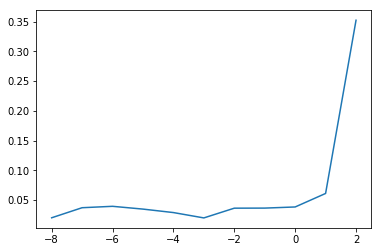

In [12]:
plt.plot(range(minL2, maxL2+1), lossArr)
plt.show()

Minimal loss is 0.0198097676039


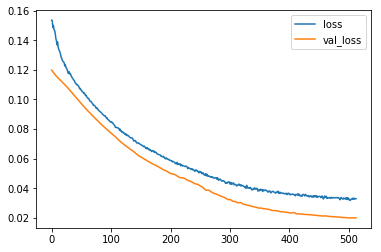

In [13]:
minLoss = np.min(lossArr)
print('Minimal loss is', minLoss)
minLossIdx = np.argmin(lossArr)
hst = hstArr[minLossIdx]
plt.plot(hst['loss'])
plt.plot(hst['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [14]:
model = modelArr[minLossIdx]

In [19]:
offest = 40
pr.postProcessOutput(model.predict(test_data_many_day_x))[offest:]

array([[ 12.91984272],
       [ 12.33154202],
       [ 11.44876194],
       [ 10.64635372],
       [  9.60280704],
       [  8.60703182],
       [  7.66898203],
       [  7.39652205],
       [  7.37290668],
       [  7.36032581],
       [  7.34851933],
       [  7.34000063],
       [  7.33909702],
       [  7.35036087],
       [  7.3517108 ],
       [  7.34234428],
       [  7.33369398],
       [  7.34373856],
       [  7.336133  ],
       [  7.30869913],
       [  7.28159952],
       [  7.26922178],
       [  7.25715876],
       [  7.24964428],
       [  7.24262428],
       [  7.23864794],
       [  7.23762035],
       [  7.2374258 ],
       [  7.23719883],
       [  7.24109936],
       [  7.24376535],
       [  7.24242973],
       [  7.24332571],
       [  7.24202967],
       [  7.2397275 ],
       [  7.24006414],
       [  7.23784304],
       [  7.22989464],
       [  7.23085546],
       [  7.23351336],
       [  7.23369074],
       [  7.23055029],
       [  7.22462463],
       [  7

In [20]:
pr.postProcessOutput(test_data_many_day_y)[offest:]

array([[  6.35783133e+00],
       [  6.69186047e+00],
       [  7.47619048e+00],
       [  6.08988764e+00],
       [  1.61555556e+00],
       [  3.90568182e+00],
       [  1.21809524e+01],
       [  6.15476190e+00],
       [  4.84943820e+00],
       [  3.90111111e+00],
       [  1.21839080e+00],
       [  4.56853933e+00],
       [  4.65280899e+00],
       [  1.76590909e+00],
       [  1.87555556e+00],
       [ -1.00113636e+00],
       [  1.10681818e+00],
       [  3.77386364e+00],
       [  7.69651163e+00],
       [  1.11204545e+01],
       [  9.83222222e+00],
       [  7.85280899e+00],
       [  6.10449438e+00],
       [  5.23258427e+00],
       [  4.56896552e+00],
       [  6.21609195e+00],
       [  4.75955056e+00],
       [  6.73707865e+00],
       [  1.92840909e+00],
       [  2.89887640e-01],
       [ -4.93258427e-01],
       [  3.14000000e+00],
       [  5.29101124e+00],
       [  5.11904762e-02],
       [ -3.74302326e+00],
       [ -4.60444444e+00],
       [ -2.91264368e+00],
 